# Intro to Jupyter Notebook

The information included here follows these webpages: https://realpython.com/jupyter-notebook-introduction/, https://medium.com/ibm-data-science-experience/back-to-basics-jupyter-notebooks-dfcdc19c54bc

## About this Notebook

### Requirements
- Direct access to the input data
- Jupyter notebook installed on that platform
- Python packages:
    - Matplotlib
    - mpl_toolkits
    - NetCDF4
    - Numpy
    
    

### Modes
- The cells are either Python 3 code (next cell), or Markdown (this cell). 
- Modes can be in either of two modes:
    - `EDIT`, which appears green
    - `COMMAND`, which appears blue
- To enter enter `EDIT` mode, hit `Enter` or double click
- To enter `COMMAND` mode, hit `Esc` or click anywhere outside the box

### Navigation
The menus at the top of the page allow you to control the cells, run them, and manage the file. 

### Keyboard commands
Many of the above navigation menus have keyboard shortcuts:

- Command Mode: ESC
- Edit Mode: ENTER
- Run selected cell: CTRL+ENTER
- Run cell and insert below: ALT+ENTER
- Run cell and select below: SHIFT+ENTER

From COMMAND mode:
- Insert cell above: A
- Insert cell below: B
- Cut selected cells: X
- Copy selected cells: C
- Delete selected cell : d+d

## Run the notebook

To run the whole notebook, use the menu: `Kernel > Restart & Run All`, or click the "Fast forward" button on the top menu bar.

To run (or rerun) a single cell, click on the cell and press `Shift, Enter`, or click the "Run" button on the top menu bar.
    

In [1]:
import os

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
import pygrib
from datetime import datetime, timedelta
from netCDF4 import Dataset
from scipy.interpolate import griddata

# Set up the input files on Hera

Abstractions to change date and location were made, but assuming the final directory structure would remain the same.

In [2]:
# Times
bkg_date = '2023061011'
valid_date = '2023061012'

# Bkg files
bkg_loc = '/work/noaa/wrfruc/span/jedi_summer_retro/nwges/' + bkg_date
file_prefix = valid_date[:-2] + '.' + valid_date[-2:] + '0000'
bkg_dynam_nc = os.path.join(bkg_loc, 'fcst_fv3lam', 'RESTART', file_prefix + '.fv_core.res.tile1.nc')
bkg_tracer_nc = os.path.join(bkg_loc, 'fcst_fv3lam', 'RESTART', file_prefix + '.fv_tracer.res.tile1.nc')

# Gsi files
gsi_loc = '/work/noaa/wrfruc/span/jedi_summer_retro/gsi_prepbufr_analysis/' + valid_date + '_singleobs'
map_nc = os.path.join(gsi_loc, 'fcst_fv3lam', 'grid_spec.nc')
gsi_dynam_nc = os.path.join(gsi_loc, 'anal_conv_dbz_gsi_upperair', 'fv3_dynvars')
gsi_tracer_nc = os.path.join(gsi_loc, 'anal_conv_dbz_gsi_upperair', 'fv3_tracer')

# Jedi files
jedi_loc = '/work/noaa/wrfruc/span/jedi_summer_retro/jedi_prepbufr_analysis/' + valid_date + '_singleobs_bgen'
jedi_dynam_nc = os.path.join(jedi_loc, 'analysis4', file_prefix + '.3denvar.c775CONUS.fv_core.res.nc')
jedi_tracer_nc = os.path.join(jedi_loc, 'analysis4', file_prefix + '.3denvar.c775CONUS.fv_tracer.res.nc')

# Load files into NetCDF Datasets
bkg_dynam = Dataset(bkg_dynam_nc, 'r')
bkg_tracer = Dataset(bkg_tracer_nc, 'r')
fv3map = Dataset(map_nc, 'r')

gsi_dynam = Dataset(gsi_dynam_nc, 'r')
gsi_tracer = Dataset(gsi_tracer_nc, 'r')
jedi_dynam = Dataset(jedi_dynam_nc, 'r')
jedi_tracer = Dataset(jedi_tracer_nc, 'r')

In [3]:
# Load latitude/longitude from background grid spec file
grid_lon = fv3map['grid_lon'][::]
grid_lat = fv3map['grid_lat'][::]

In [4]:
# var_loc is a dictionary that describes which Python variables contain the desired atmospheric variables.
# For example, the sphum variable is found only in the tracer files, while u, v, and T are found in the dynam files.
var_loc = {
    'u': {
        'gsi': gsi_dynam,
        'jedi': jedi_dynam,
        'bkg': bkg_dynam,
    },
    'v':  {
        'gsi': gsi_dynam,
        'jedi': jedi_dynam,
        'bkg': bkg_dynam,
    },
    'T':  {
        'gsi': gsi_dynam,
        'jedi': jedi_dynam,
        'bkg': bkg_dynam,
    },
    'sphum':  {
        'gsi': gsi_tracer,
        'jedi': jedi_tracer,
        'bkg': bkg_tracer,
    },
}

In [5]:
def trim_grid(data, lat, lon):
    '''
    The u, v, and H data are all on grids either one column, or one row smaller than lat/lon. 
    Return the smaller lat, lon grids, given the shape of the data to be plotted.
    '''
    y, x = np.shape(data)
    return lat[:y, :x], lon[:y, :x]

def find_max_index(data):
    '''
    Input parameters:
        data: 3D Numpy array
    Returns:
        Tuple of indices (i, j, k) corresponding to the maximum value in the 3D array
    '''
    # Find the index of the maximum value in the flattened array
    flat_index = np.argmax(np.abs(data))
    
    # Convert the flattened index back to 3D index
    index_3d = np.unravel_index(flat_index, data.shape)
    
    return index_3d

def eq_contours1(data):
    minval = np.amin(data)
    maxval = np.amax(data)
    if minval < 0:
        # Set balanced contours. Choose an odd number in linspace below
        maxval = max(abs(minval), abs(maxval))
        return np.linspace(-maxval, maxval, 21)
    else:
        return np.linspace(minval, maxval, 21)

def eq_contours2(data1, data2):
    minval = np.min([np.amin(data1), np.amin(data2)])
    maxval = np.max([np.amax(data1), np.amax(data2)])
    if minval < 0:
        # Set balanced contours. Choose an odd number in linspace below
        maxval = max(abs(minval), abs(maxval))
        return np.linspace(-maxval, maxval, 21)
    else:
        return np.linspace(minval, maxval, 21)

In [6]:
def plot_data(data1, data2, lat, lon, title1, title2):
    
    '''
    Input parameters:
    
        data: 2D Numpy array to be plotted
        lat: 2D Numpy array of latitude
        lon: 2D Numpy array of longitude
        var: String describing the variable being plotted.
        
    Draws a Basemap representation with the contoured data overlayed, with a colorbar.
        
    ''' 
    
    contourLevel = eq_contours2(data1, data2)
    print(contourLevel)

    fig, axes = plt.subplots(1, 2, figsize=(24, 12), constrained_layout=True)
    
    # Subfigure 1
    ax1 = axes[0]
    m1 = Basemap(projection='mill',
                 llcrnrlon=lon.min()+33,
                 urcrnrlon=lon.max()-33,
                 llcrnrlat=lat.min()+11,
                 urcrnrlat=lat.max()-13,
                 resolution='c',
                 ax=ax1)
    lat_trim, lon_trim = trim_grid(data1, lat, lon)
    x, y = m1(lon_trim, lat_trim)
    cs1 = m1.contourf(x, y, data1, contourLevel, cmap='seismic')
    m1.drawcoastlines()
    m1.drawcountries()
    m1.drawstates()
    m1.drawparallels(np.arange(-90.,120.,5),labels=[1,0,0,0], fontsize=16);
    m1.drawmeridians(np.arange(-180.,180.,10),labels=[0,0,0,1], fontsize=16);
    ax1.set_title(title1, fontsize=24)
    
    # Subfigure 2
    ax2 = axes[1]
    m2 = Basemap(projection='mill',
                 llcrnrlon=lon.min()+33,
                 urcrnrlon=lon.max()-33,
                 llcrnrlat=lat.min()+11,
                 urcrnrlat=lat.max()-13,
                 resolution='c',
                 ax=ax2)
    x, y = m2(lon_trim, lat_trim)
    cs2 = m2.contourf(x, y, data2, contourLevel, cmap='seismic')
    m2.drawcoastlines()
    m2.drawcountries()
    m2.drawstates()
    m2.drawparallels(np.arange(-90.,120.,5),labels=[1,0,0,0], fontsize=16);
    m2.drawmeridians(np.arange(-180.,180.,10),labels=[0,0,0,1], fontsize=16);
    ax2.set_title(title2, fontsize=24)
    
    cb = fig.colorbar(cs2, ax=axes, orientation='horizontal', aspect=50, fraction=0.05, pad=0.05)
    cb.ax.tick_params(labelsize=16)

#    m = Basemap(projection='mill', 
#                llcrnrlon=lon.min()-1,
#                urcrnrlon=lon.max()+1,
#                llcrnrlat=lat.min()-1,
#                urcrnrlat=lat.max()+1,
##                 llcrnrlon=276-10,
##                 urcrnrlon=276+10,
##                 llcrnrlat=35-10,
##                 urcrnrlat=35+10,
#                resolution='c',
#               )
#
#    lat_trim, lon_trim = trim_grid()
#    plt.figure(figsize=(12,12))
#    x, y = m(lon_trim, lat_trim)
#    
#    # Check out this link for all cmap options: https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html
#    # A good redwhiteblue cmap for increments is seismic, and for full fields with rainbow, change to hsv
#    cs = m.contourf(x, y, data, eq_contours(), cmap='seismic')
#    m.drawcoastlines();
#    m.drawmapboundary();
#    m.drawparallels(np.arange(-90.,120.,5),labels=[1,0,0,0], fontsize=16);
#    m.drawmeridians(np.arange(-180.,180.,10),labels=[0,0,0,1], fontsize=16);
#    plt.colorbar(cs,orientation='vertical', shrink=0.5);
#    plt.title(f"{title}", fontdict = {'fontsize' : 24})

In [7]:
def plot_data_1dvert(data1, data2, i1, j1, i2, j2):
    '''
    Input parameters:
        data1: 3D Numpy array for the first dataset
        data2: 3D Numpy array for the second dataset
        i1: Index along the first dimension for the first dataset
        j1: Index along the second dimension for the first dataset
        i2: Index along the first dimension for the second dataset
        j2: Index along the second dimension for the second dataset
    Plots the vertical profiles at the specified (i1, j1) and (i2, j2) coordinates along the k axis.
    '''
    # Extract the vertical profiles at the specified coordinates
    vertical_profile1 = data1[:, j1, i1]
    vertical_profile2 = data2[:, j2, i2]
    
    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot the first vertical profile
    axes[0].plot(vertical_profile1, range(len(vertical_profile1)), '-o')
    axes[0].set_xlabel('Increment')
    axes[0].set_ylabel('Level')
    axes[0].set_title(f"GSI Increment at ({i1}, {j1})")
    axes[0].invert_yaxis()  # Invert y-axis if k represents depth or altitude
    axes[0].grid(True)
    
    # Plot the second vertical profile
    axes[1].plot(vertical_profile2, range(len(vertical_profile2)), '-o')
    axes[1].set_xlabel('Increment')
    axes[1].set_ylabel('Level')
    axes[1].set_title(f"JEDI Increment at ({i2}, {j2})")
    axes[1].invert_yaxis()  # Invert y-axis if k represents depth or altitude
    axes[1].grid(True)

In [8]:
def plot_bkg(data, lat, lon, title):
    
    '''
    Input parameters:
    
        data: 2D Numpy array to be plotted
        lat: 2D Numpy array of latitude
        lon: 2D Numpy array of longitude
        var: String describing the variable being plotted.
        
    Draws a Basemap representation with the contoured data overlayed, with a colorbar.
        
    '''
    
    contourLevel = eq_contours1(data)
    
    m = Basemap(projection='mill', 
                llcrnrlon=lon.min()-1,
                urcrnrlon=lon.max()+1,
                llcrnrlat=lat.min()-1,
                urcrnrlat=lat.max()+1,
#                 llcrnrlon=276-10,
#                 urcrnrlon=276+10,
#                 llcrnrlat=35-10,
#                 urcrnrlat=35+10,
                resolution='c',
               )

    lat_trim, lon_trim = trim_grid(data, lat, lon)
    plt.figure(figsize=(12,12))
    x, y = m(lon_trim, lat_trim)
    
    # Check out this link for all cmap options: https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html
    # A good redwhiteblue cmap for increments is seismic, and for full fields with rainbow, change to hsv
    cs = m.contourf(x, y, data, contourLevel, cmap='seismic')
    m.drawcoastlines();
    m.drawmapboundary();
    m.drawparallels(np.arange(-90.,120.,5),labels=[1,0,0,0], fontsize=16);
    m.drawmeridians(np.arange(-180.,180.,10),labels=[0,0,0,1], fontsize=16);
    plt.colorbar(cs,orientation='vertical', shrink=0.5);
    plt.title(f"{title}", fontdict = {'fontsize' : 24})

# Plot the variables

Loop through each of the variables contained in the keys of `var_loc`, get the data from the appropriate Python variable, and plot the results.

In [9]:
### find the level where variable field has max values
def find_lev_max(var3d):
    nlev=np.shape(var3d)[0]
    varmax=max(np.amax(var3d[i,:,:]) for i  in range(nlev))
#     print(varmax)
    for i in range(nlev):
        if np.amax(var3d[i,:,:])==varmax :
            zmax=i
#     print(zmax)
    return zmax

In [10]:
# # finding level of max T for temp psot
# anl_T, bkg_T = [var_loc["T"][stage]["T"][::] for stage in ['anl', 'bkg']]
# diff=np.squeeze(anl_T)[:, :, :]-np.squeeze(bkg_T)[:, :, :]
# lev=find_lev_max(diff)
# print(lev)
# # plot_data(np.squeeze(anl)[lev, :, :]-np.squeeze(bkg)[lev, :, :], grid_lat, grid_lon, title)


Processing variable: u
[-0.10685527 -0.09616975 -0.08548422 -0.07479869 -0.06411316 -0.05342764
 -0.04274211 -0.03205658 -0.02137105 -0.01068553  0.          0.01068553
  0.02137105  0.03205658  0.04274211  0.05342764  0.06411316  0.07479869
  0.08548422  0.09616975  0.10685527]
Processing variable: v
[-0.1092267  -0.09830403 -0.08738136 -0.07645869 -0.06553602 -0.05461335
 -0.04369068 -0.03276801 -0.02184534 -0.01092267  0.          0.01092267
  0.02184534  0.03276801  0.04369068  0.05461335  0.06553602  0.07645869
  0.08738136  0.09830403  0.1092267 ]
Processing variable: T
[-0.13824463 -0.12442017 -0.1105957  -0.09677124 -0.08294678 -0.06912231
 -0.05529785 -0.04147339 -0.02764893 -0.01382446  0.          0.01382446
  0.02764893  0.04147339  0.05529785  0.06912231  0.08294678  0.09677124
  0.1105957   0.12442017  0.13824463]
Processing variable: sphum
[-0.09386444 -0.084478   -0.07509155 -0.06570511 -0.05631866 -0.04693222
 -0.03754578 -0.02815933 -0.01877289 -0.00938644  0.        

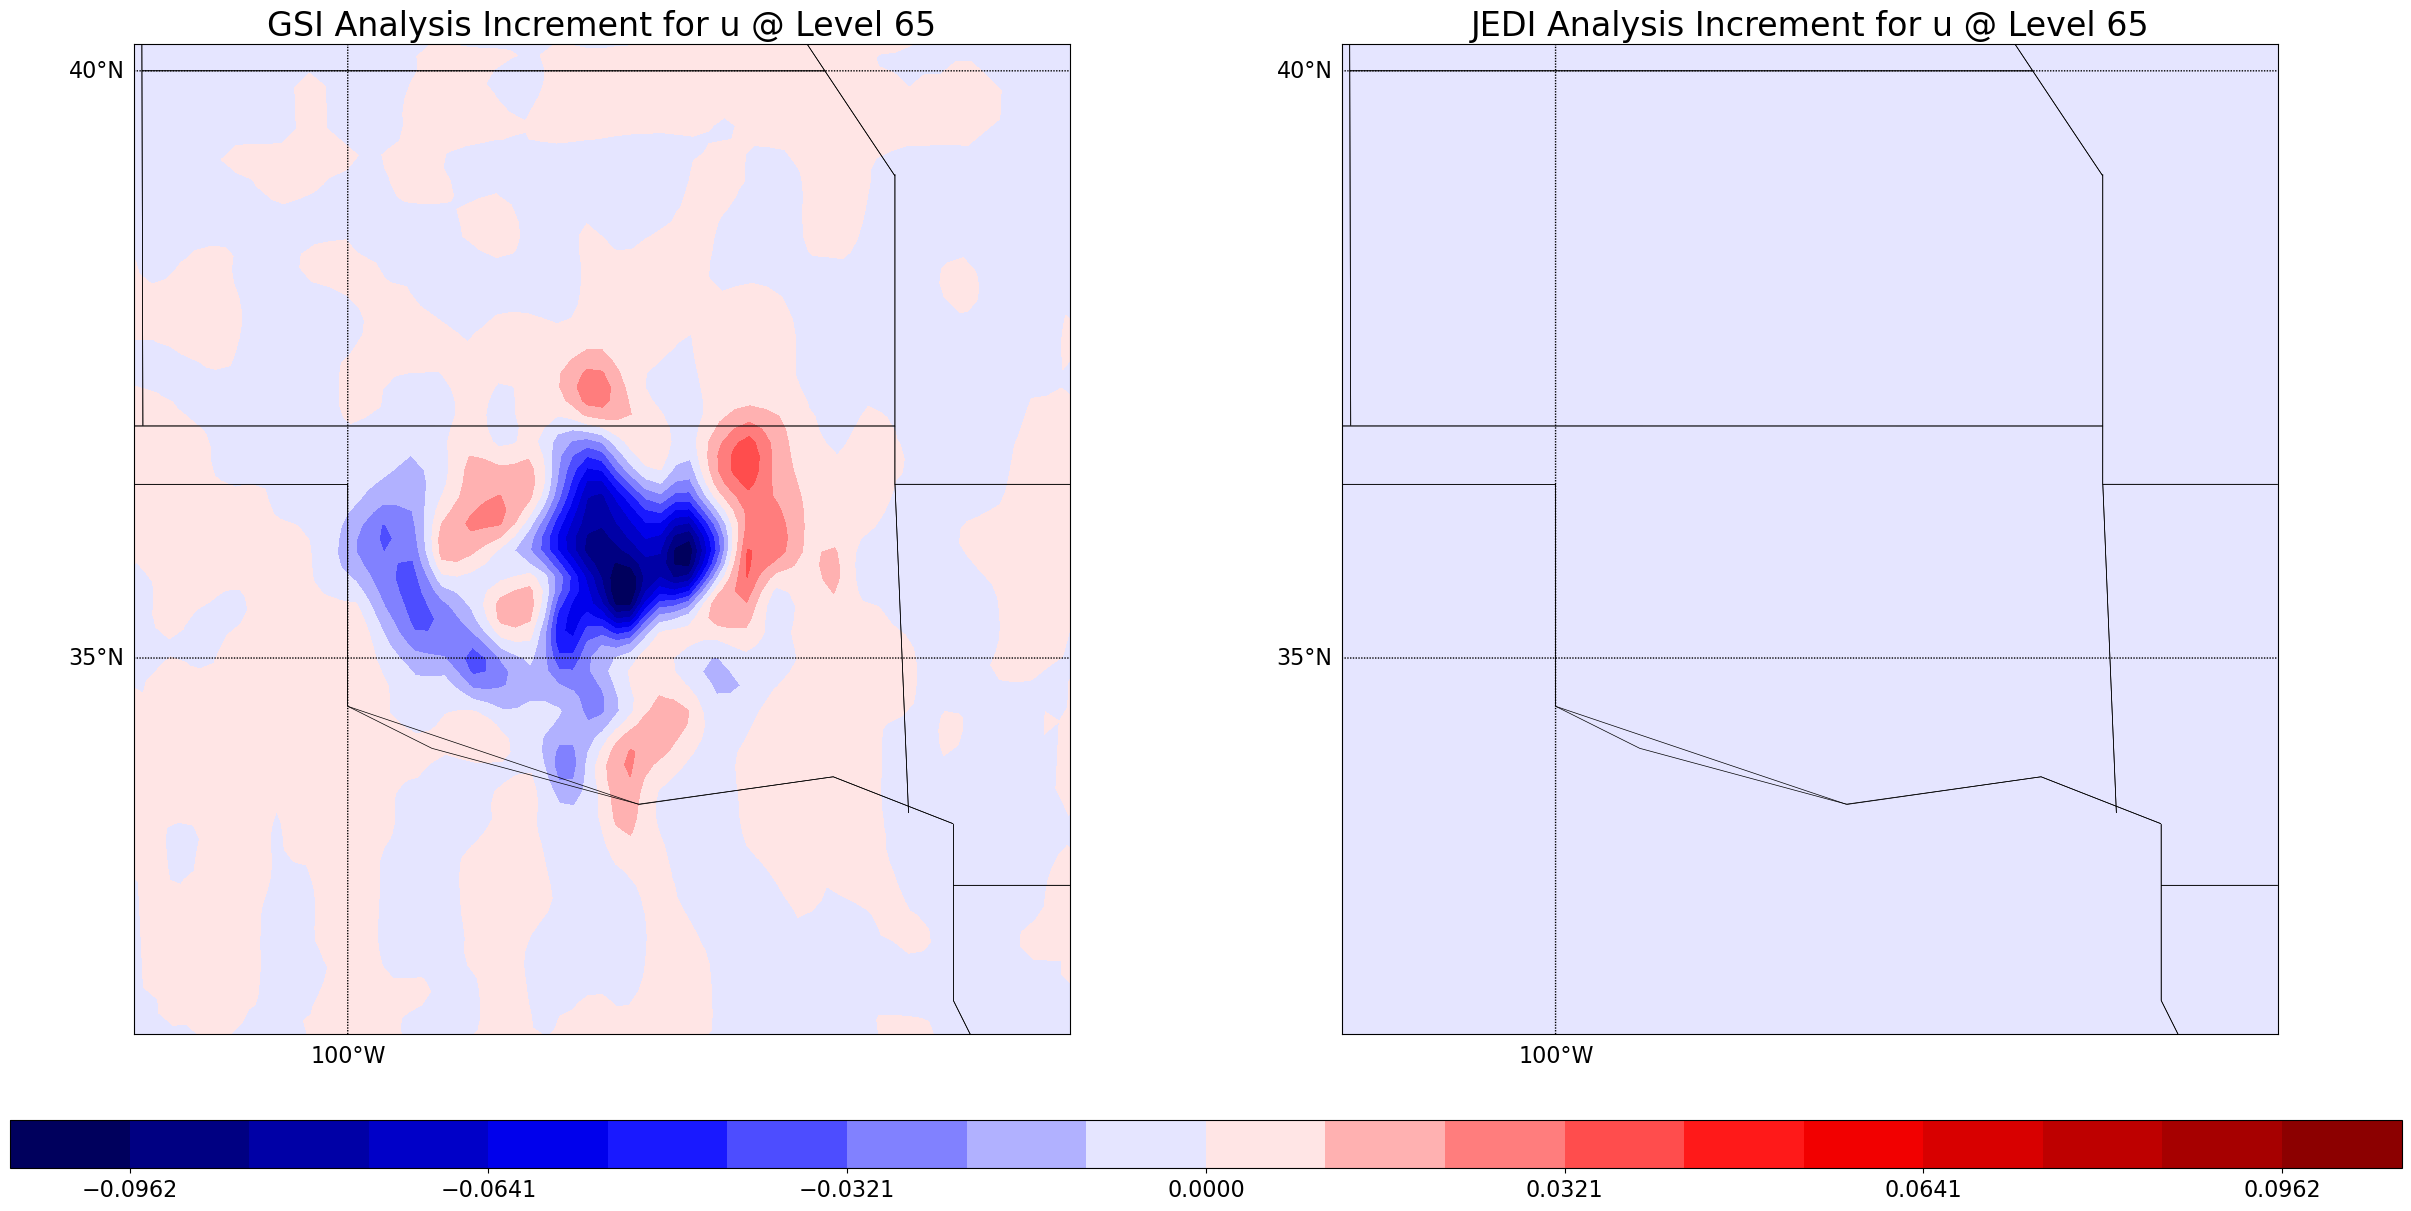

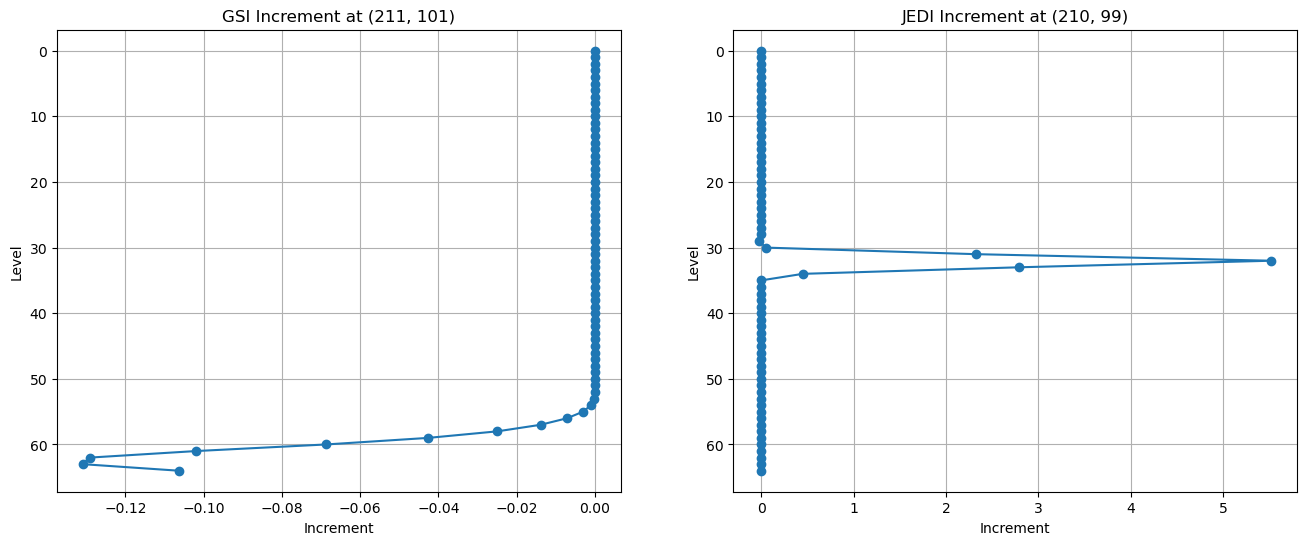

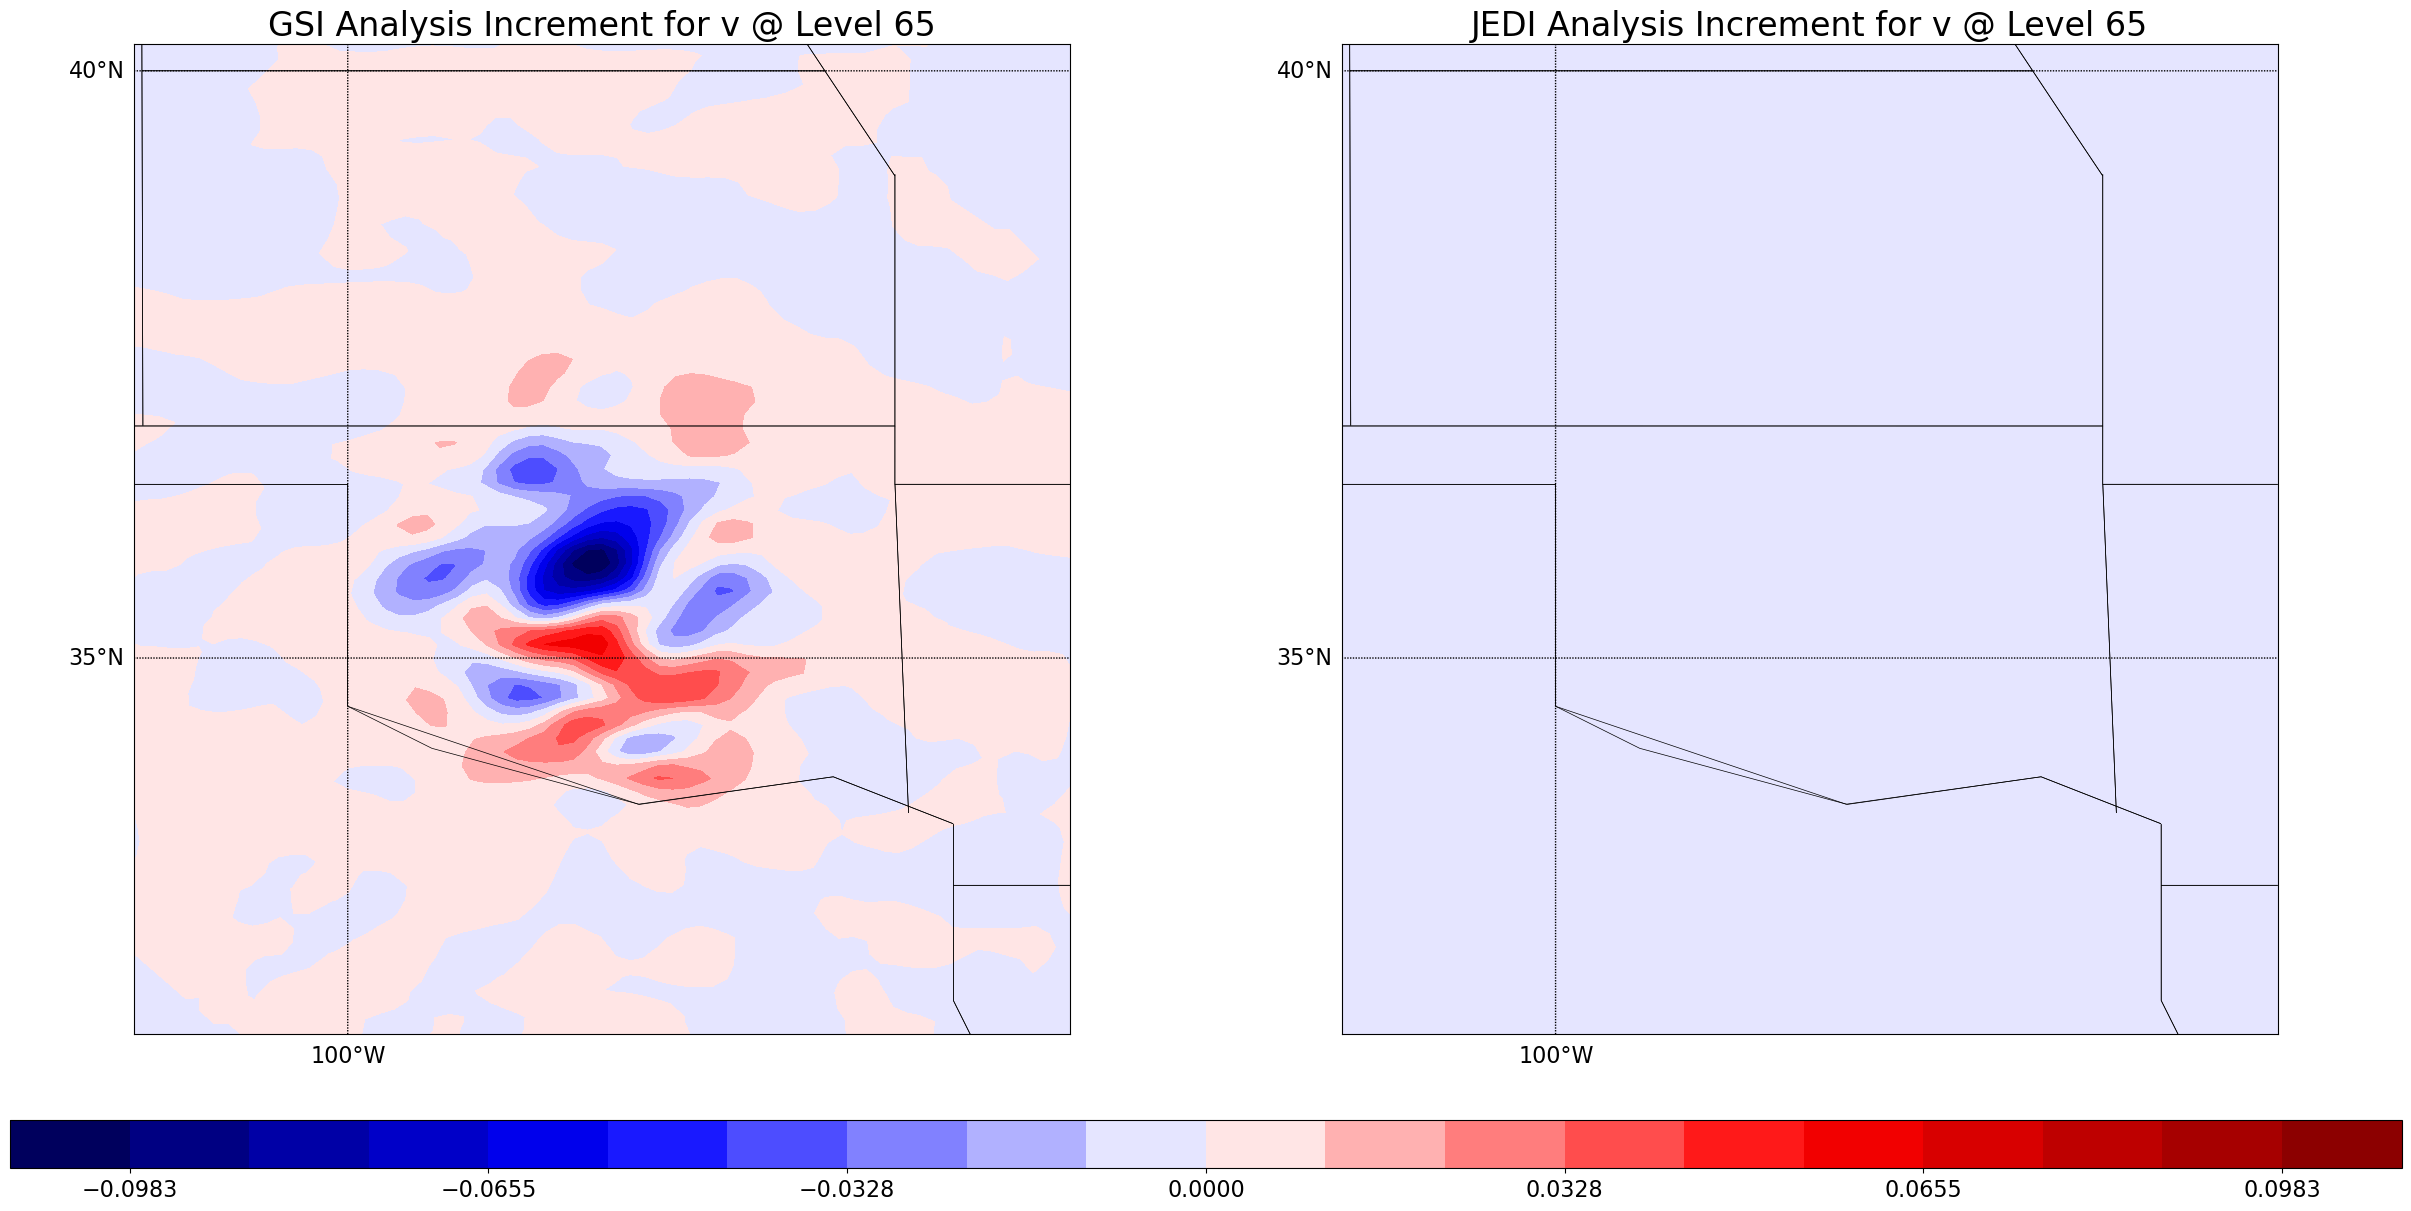

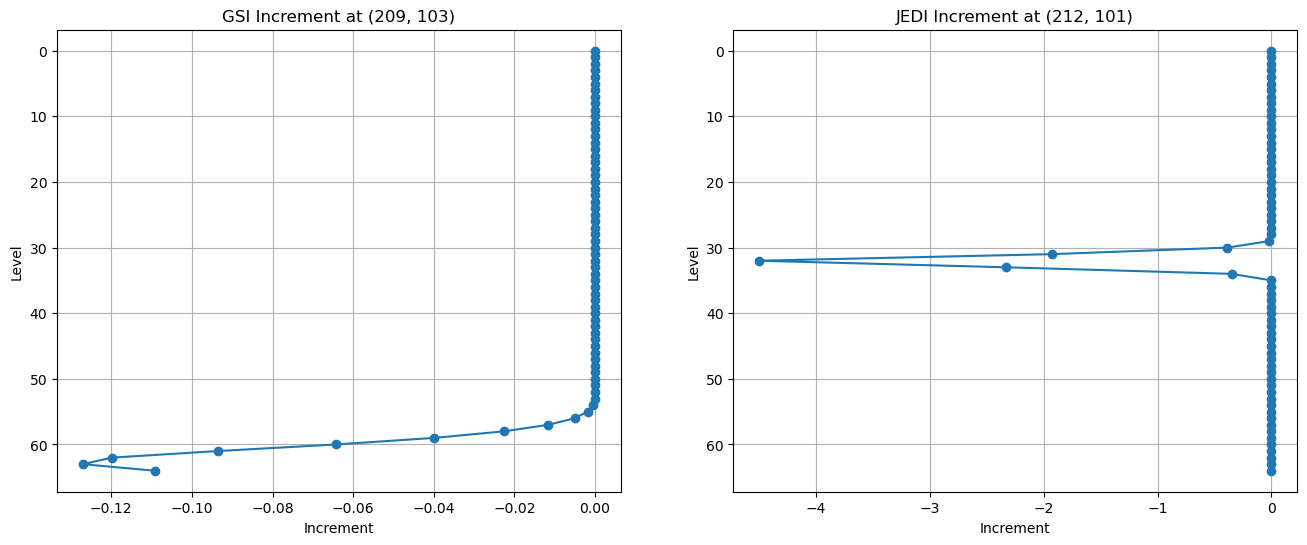

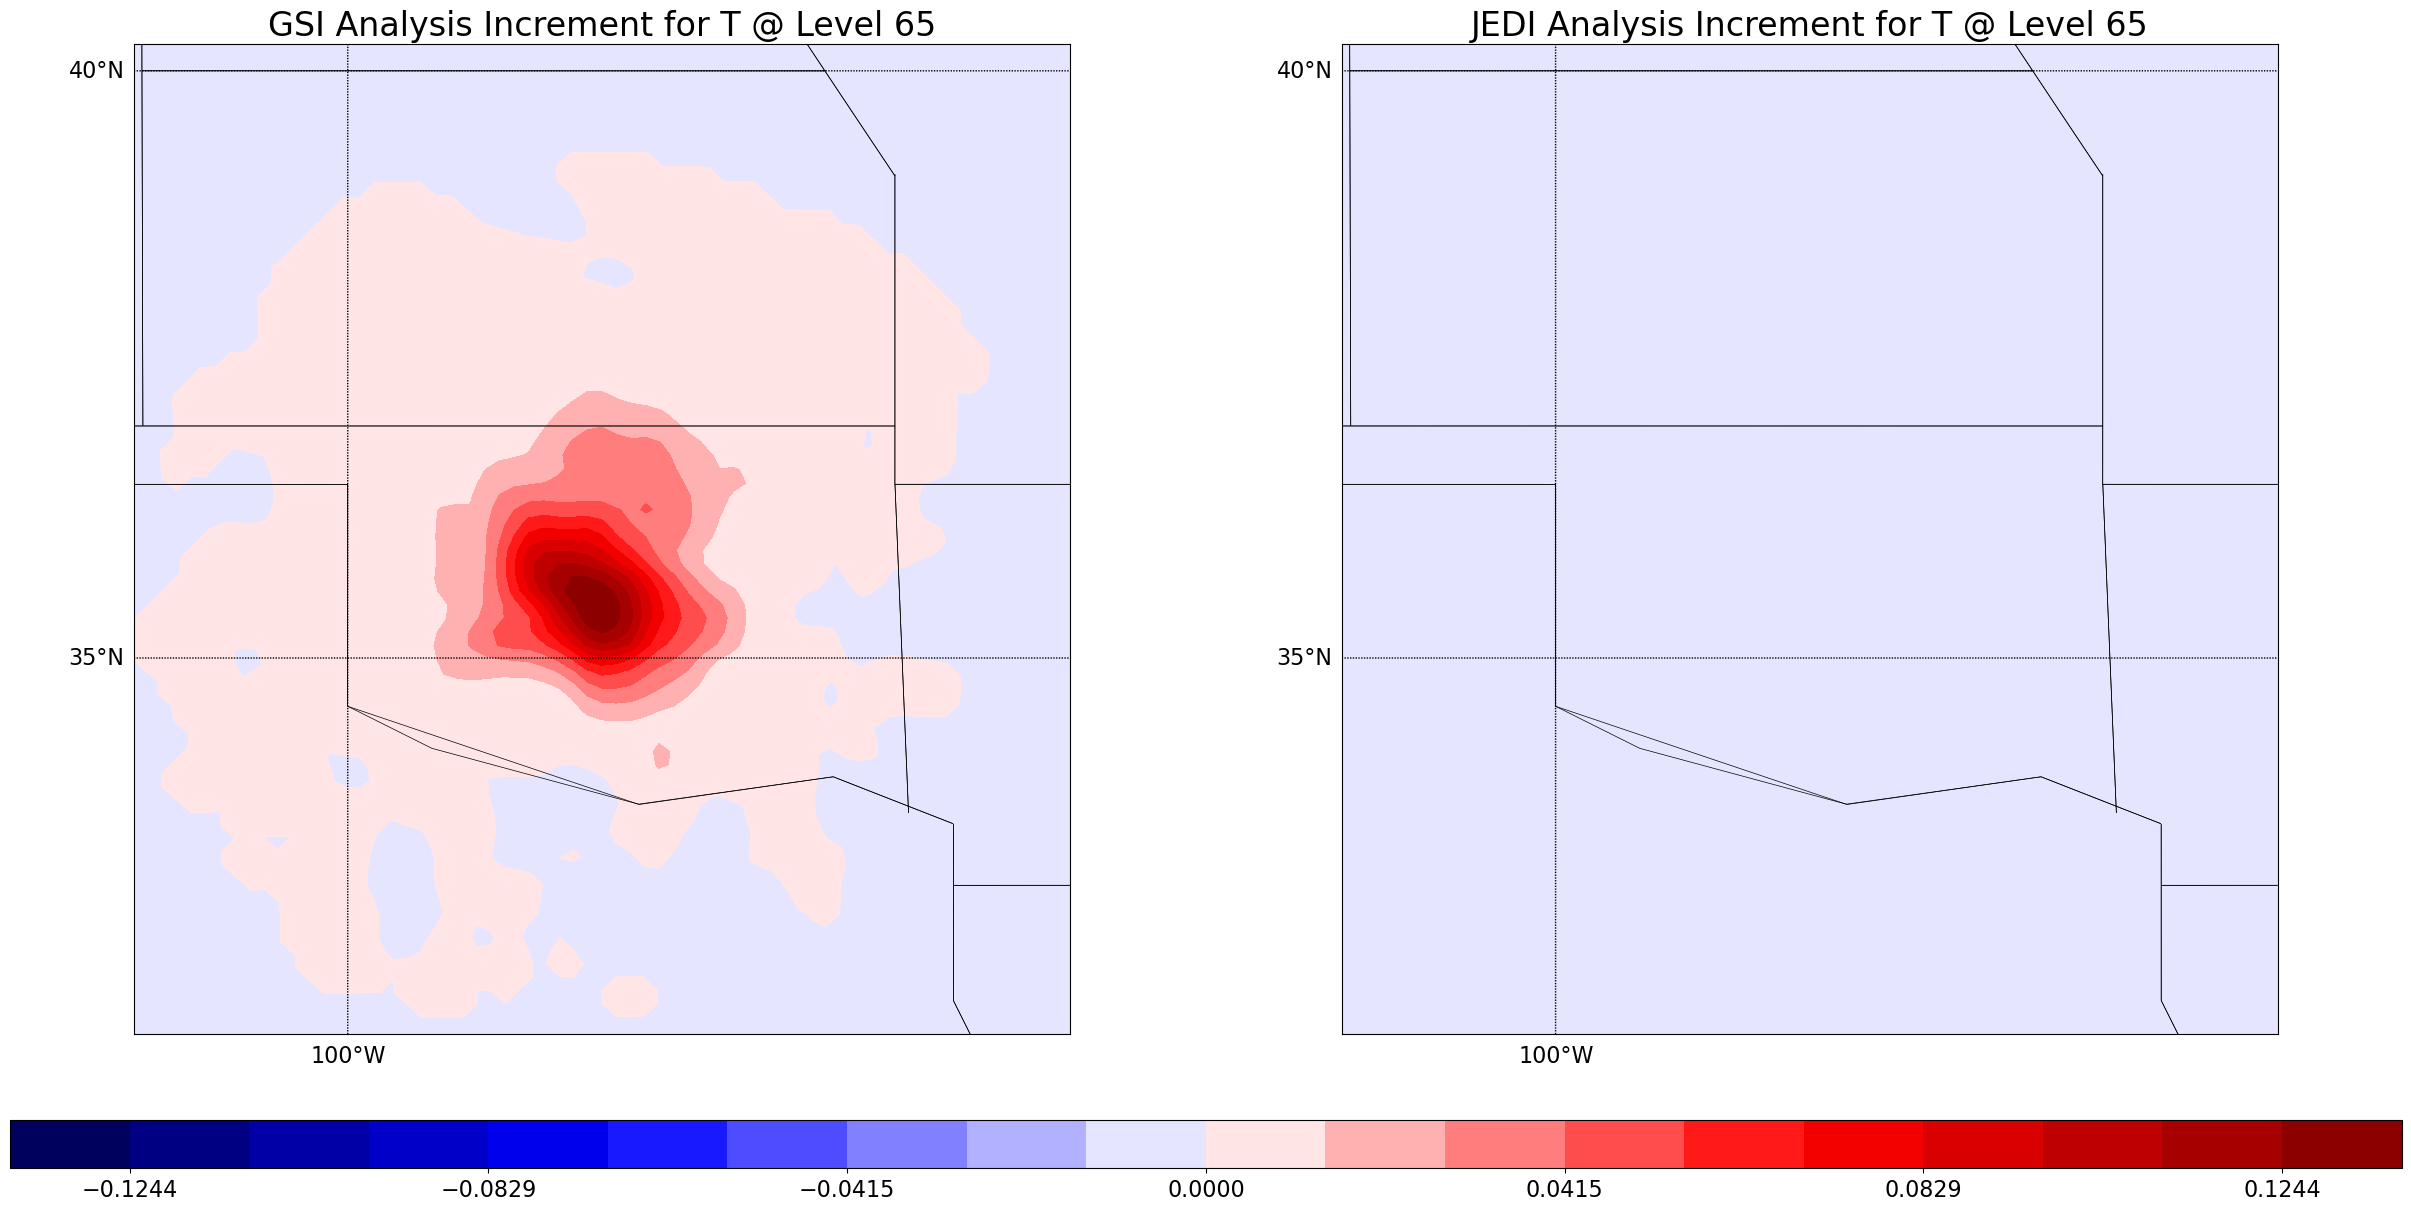

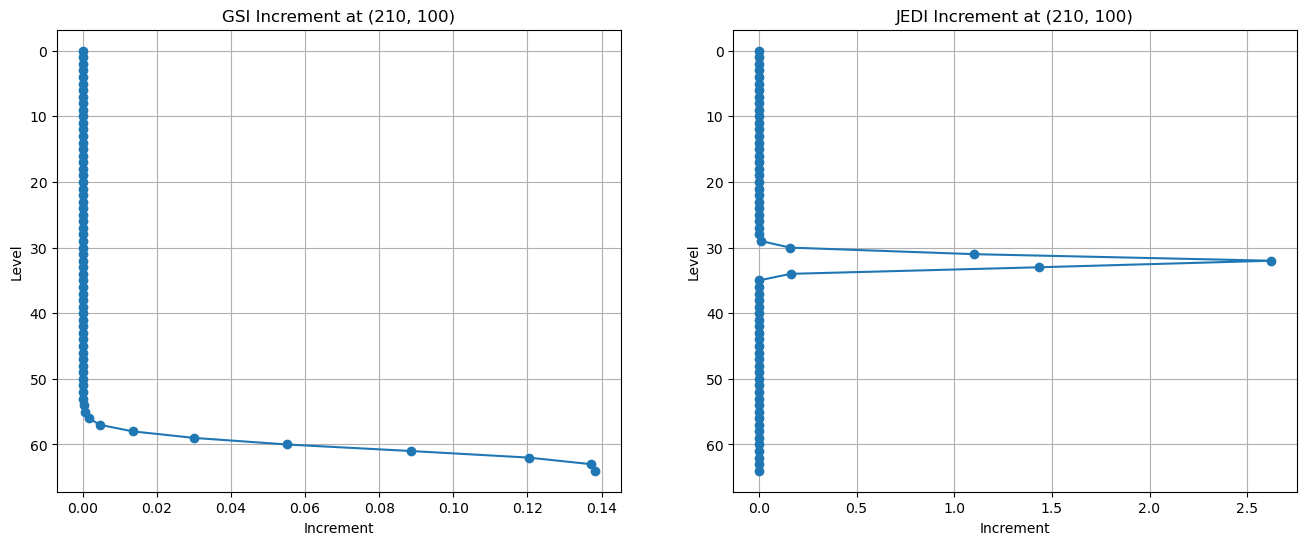

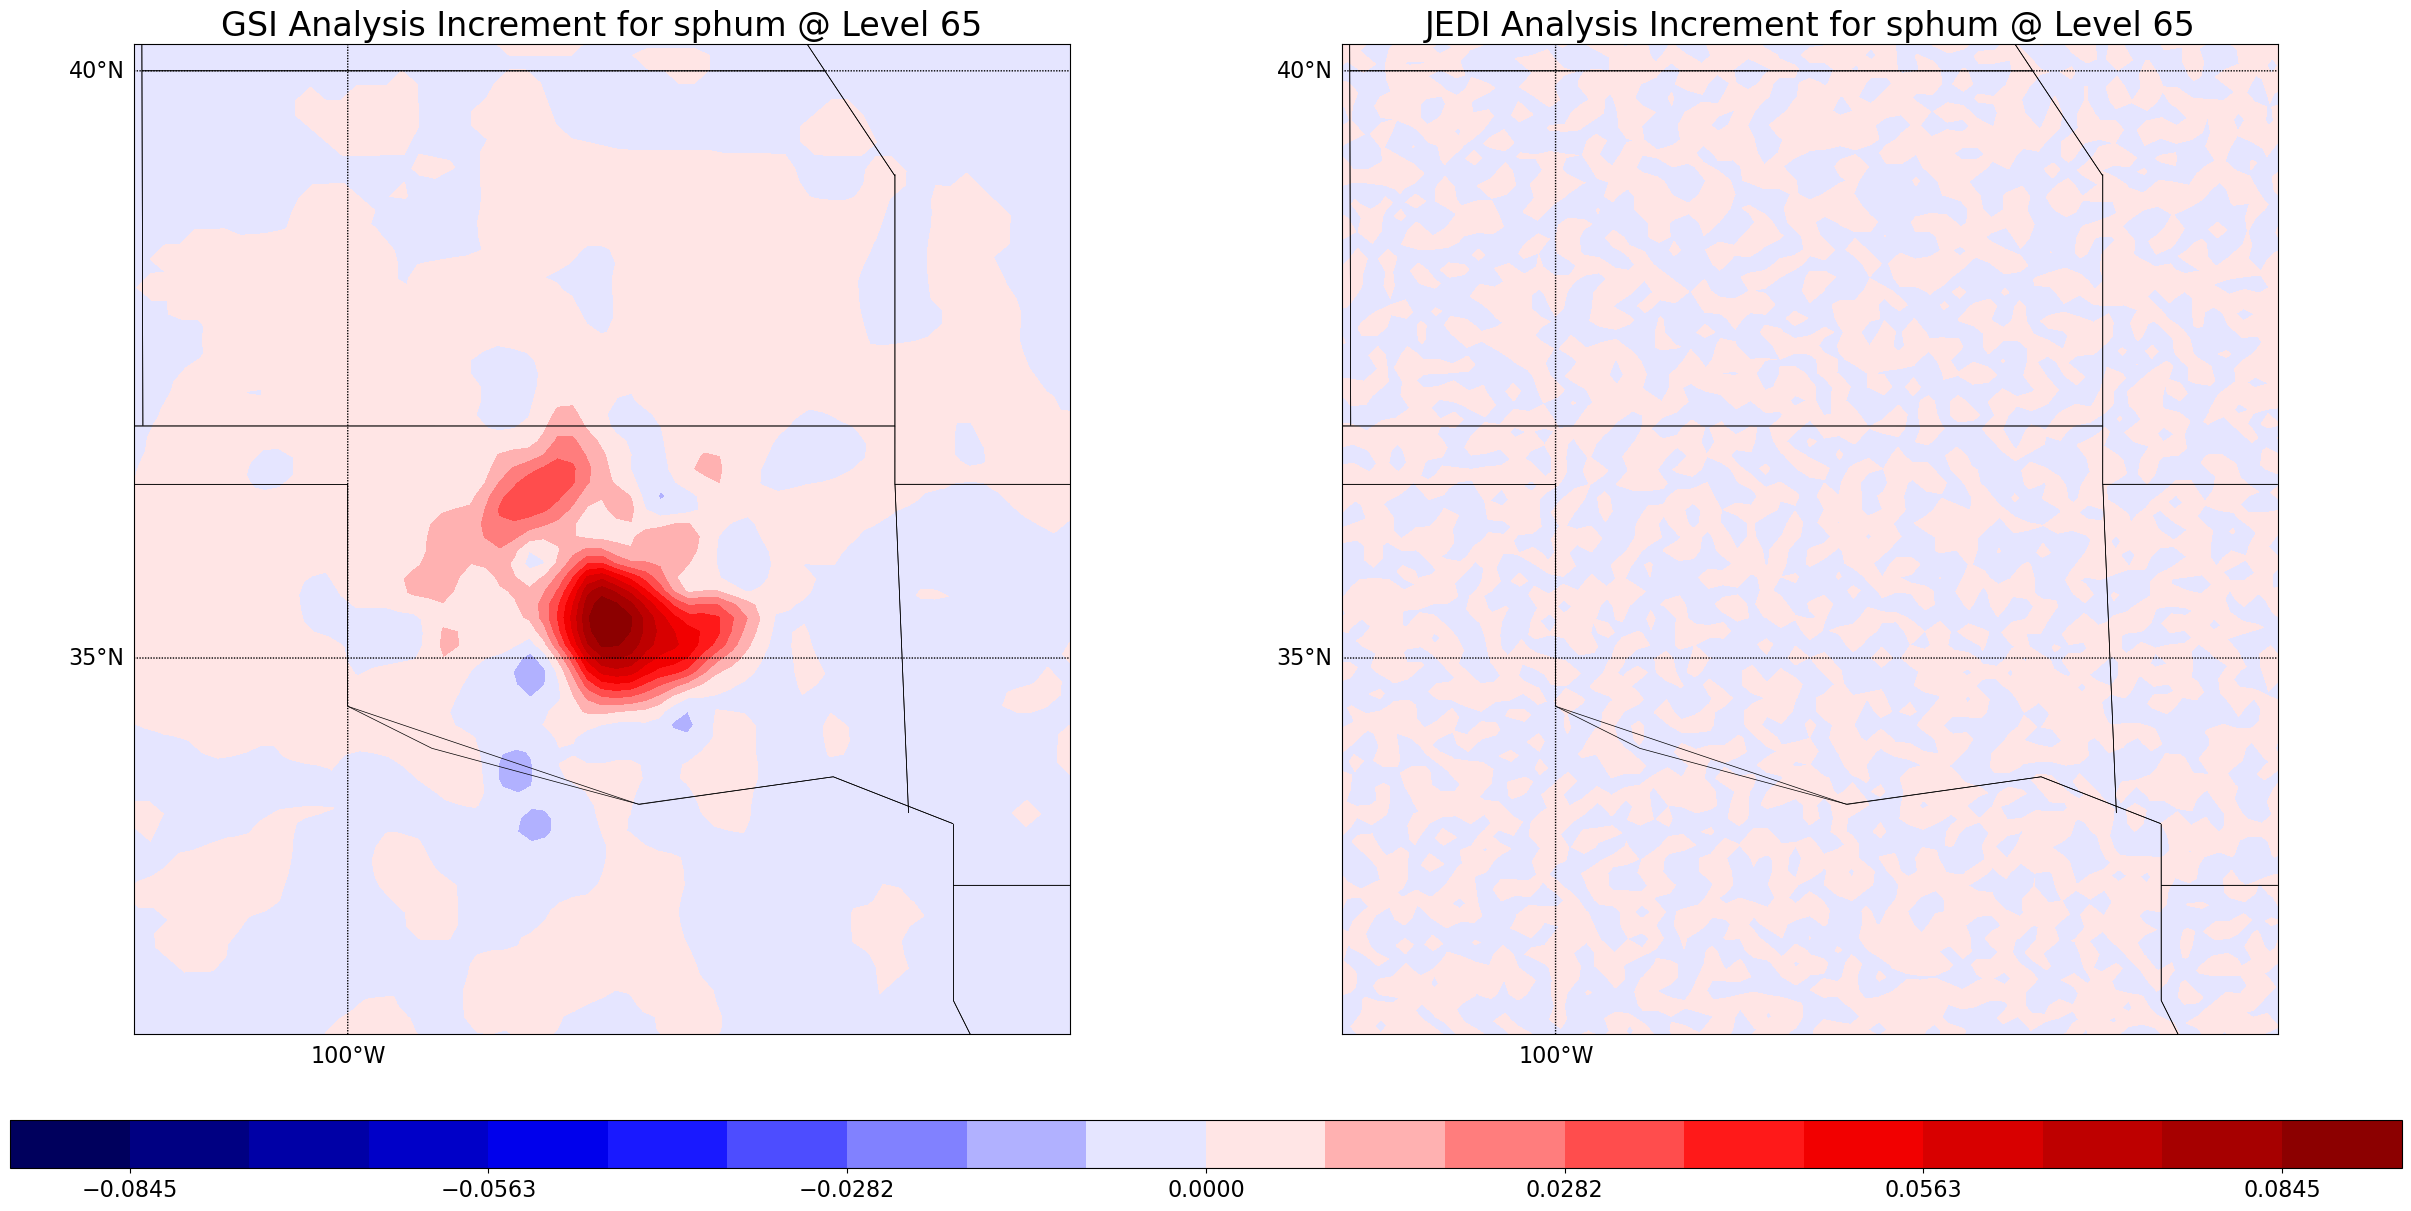

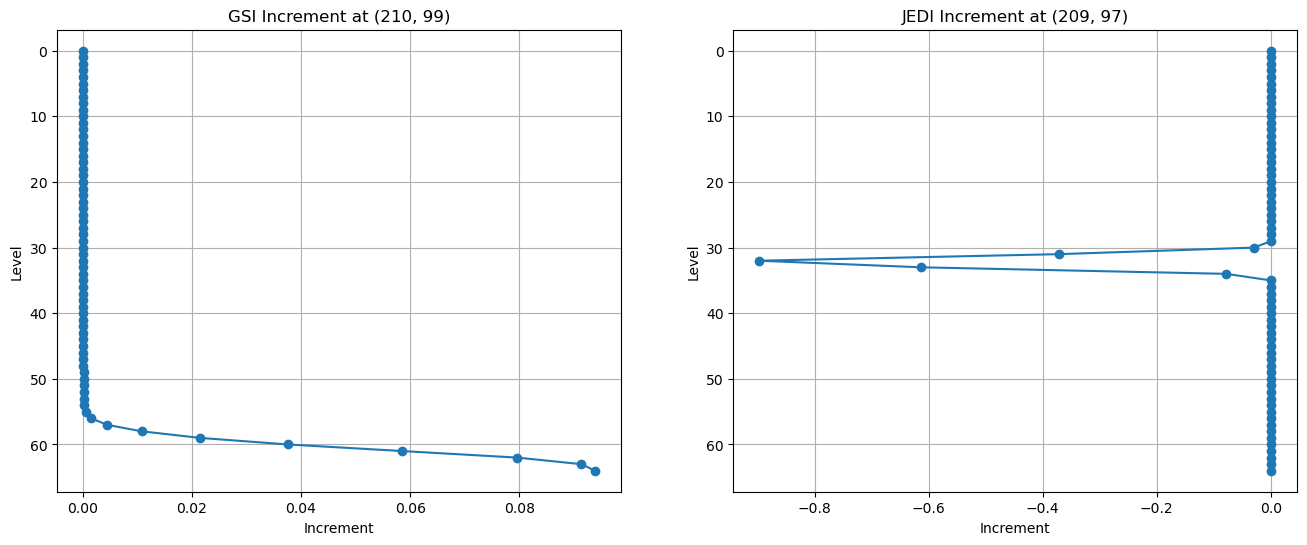

In [11]:
#for var in var_loc.keys():
#    print("Processing variable: {}".format(var))
#    for lev in [64, ]:   # Change this variable to look at different vertical levels.       
#        gsi, jedi, bkg = [var_loc[var][stage][var][::] for stage in ['gsi', 'jedi', 'bkg']]
#        if var == "sphum":
#            gsi = gsi * 1000.
#            jedi = jedi * 1000.
#            bkg = bkg * 1000.
#        title1 = f'GSI Analysis Increment for {var} @ Level {lev+1}'
#        title2 = f'JEDI Analysis Increment for {var} @ Level {lev+1}'
#        gsi_increment = np.squeeze(gsi)[lev, :, :]-np.squeeze(bkg)[lev, :, :]
#        jedi_increment = np.squeeze(jedi)[lev, :, :]-np.squeeze(bkg)[lev, :, :]
#        plot_data(gsi_increment, jedi_increment, grid_lat, grid_lon, title1, title2)
#    gsi_increment = np.squeeze(gsi)[:, :, :]-np.squeeze(bkg)[:, :, :]
#    jedi_increment = np.squeeze(jedi)[:, :, :]-np.squeeze(bkg)[:, :, :]
#    (k1, j1, i1) = find_max_index(gsi_increment)
#    (k1, j2, i2) = find_max_index(jedi_increment)
#    plot_data_1dvert(gsi_increment, jedi_increment, i1, j1, i2, j2)

Processing variable: u
[-5.51993035 -4.96793731 -4.41594428 -3.86395124 -3.31195821 -2.75996517
 -2.20797214 -1.6559791  -1.10398607 -0.55199303  0.          0.55199303
  1.10398607  1.6559791   2.20797214  2.75996517  3.31195821  3.86395124
  4.41594428  4.96793731  5.51993035]
Processing variable: v
[-4.50000238 -4.05000214 -3.6000019  -3.15000166 -2.70000143 -2.25000119
 -1.80000095 -1.35000071 -0.90000048 -0.45000024  0.          0.45000024
  0.90000048  1.35000071  1.80000095  2.25000119  2.70000143  3.15000166
  3.6000019   4.05000214  4.50000238]
Processing variable: T
[-2.62397953 -2.36158158 -2.09918362 -1.83678567 -1.57438772 -1.31198976
 -1.04959181 -0.78719386 -0.52479591 -0.26239795  0.          0.26239795
  0.52479591  0.78719386  1.04959181  1.31198976  1.57438772  1.83678567
  2.09918362  2.36158158  2.62397953]
Processing variable: sphum
[-0.89727217 -0.80754495 -0.71781773 -0.62809052 -0.5383633  -0.44863608
 -0.35890887 -0.26918165 -0.17945443 -0.08972722  0.        

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

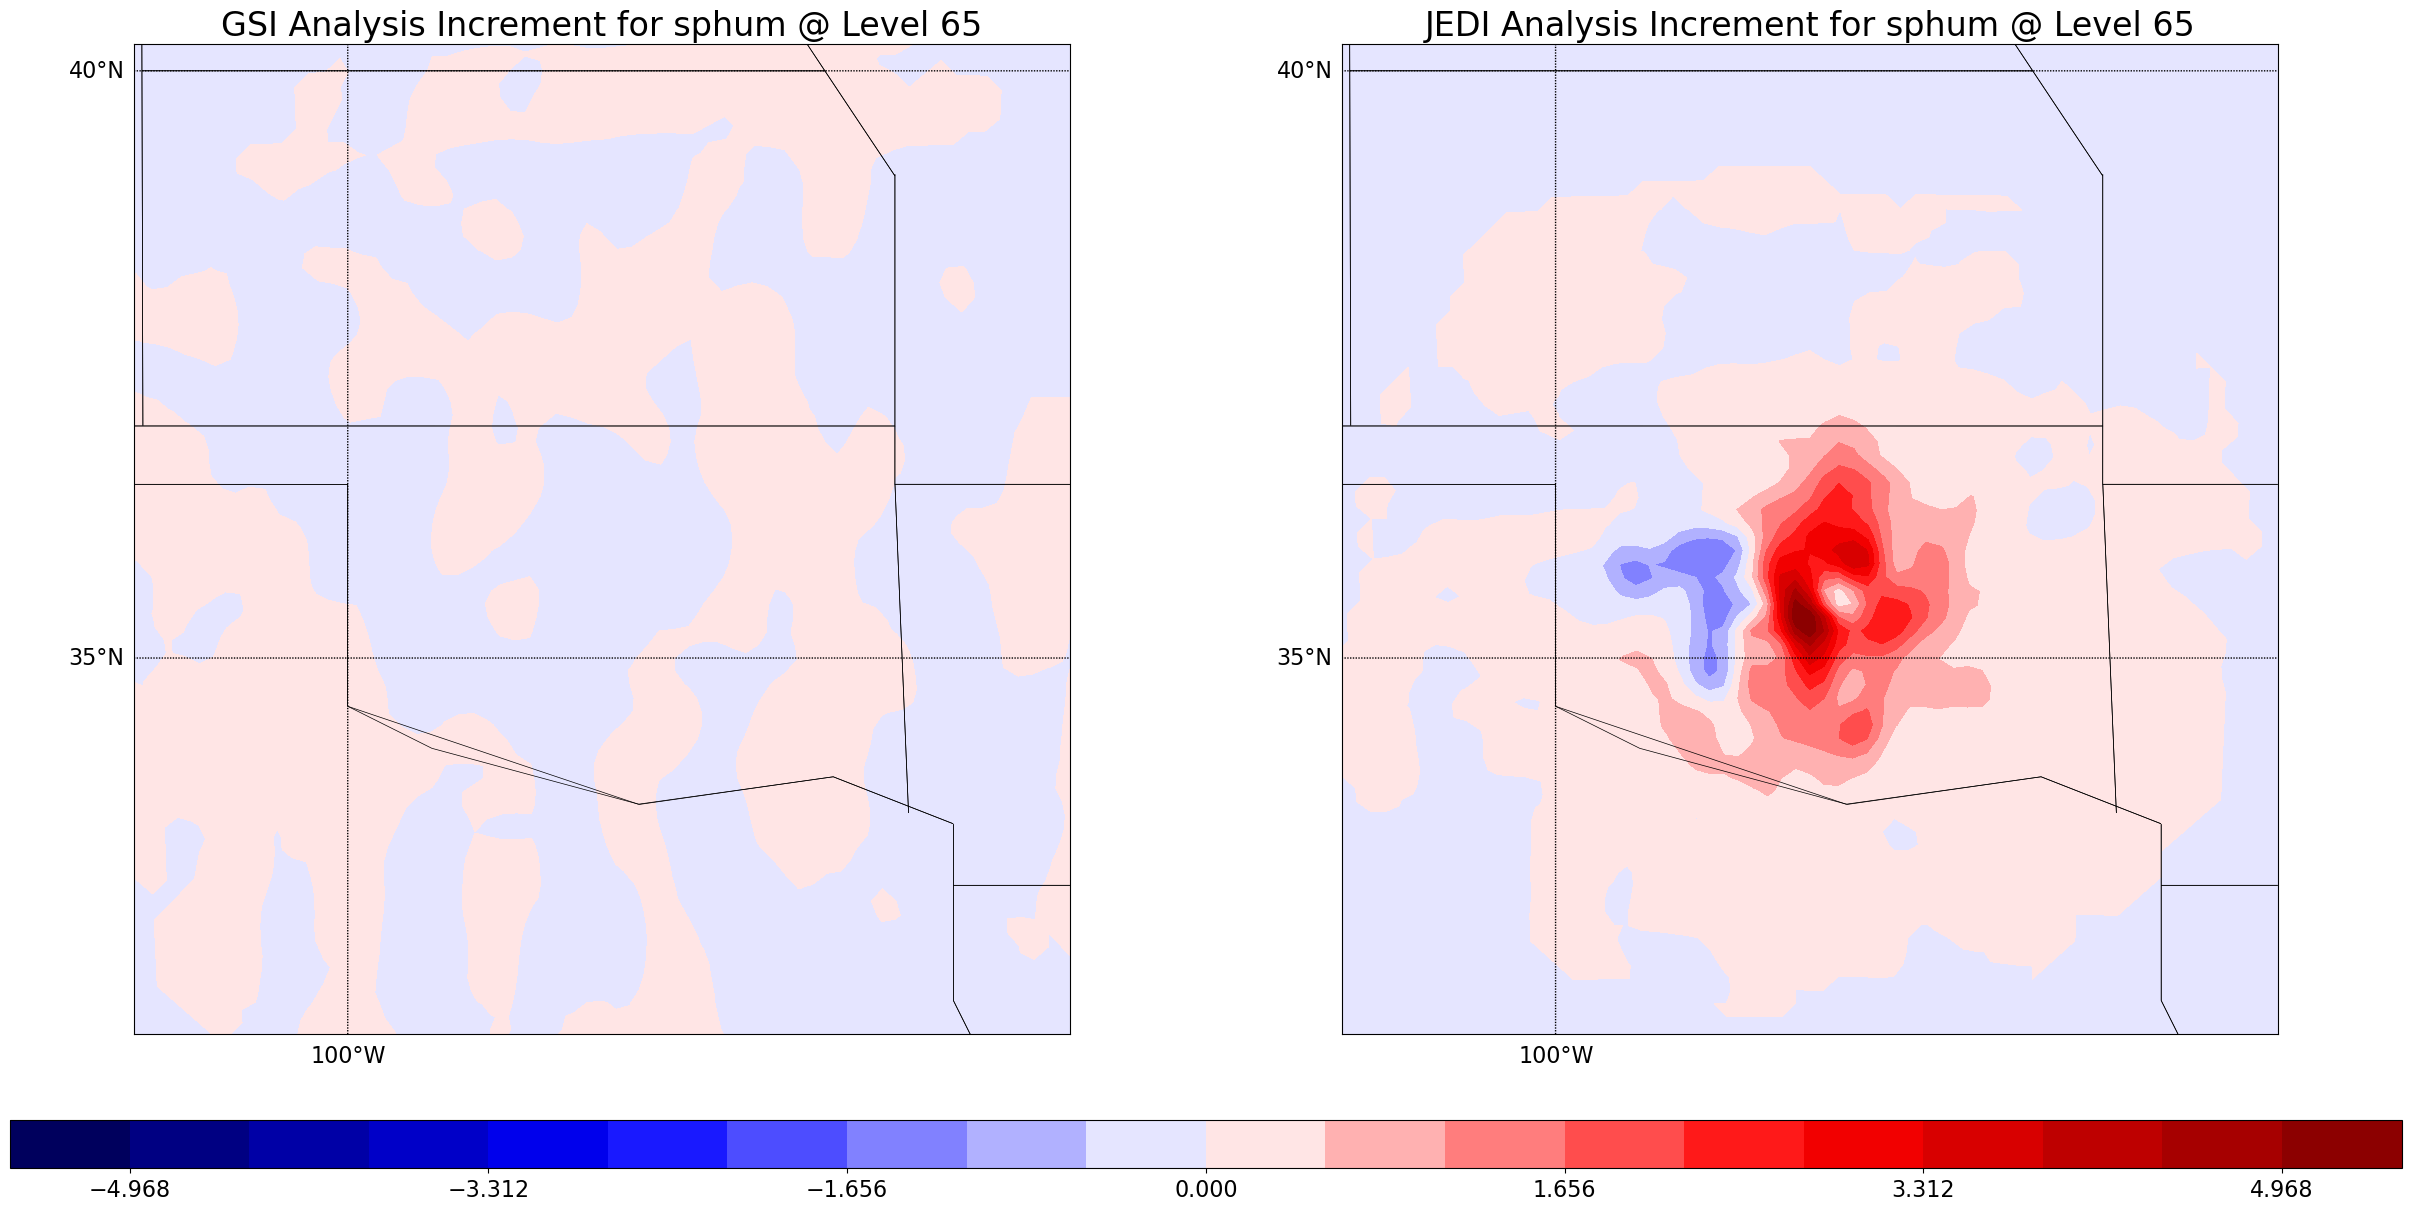

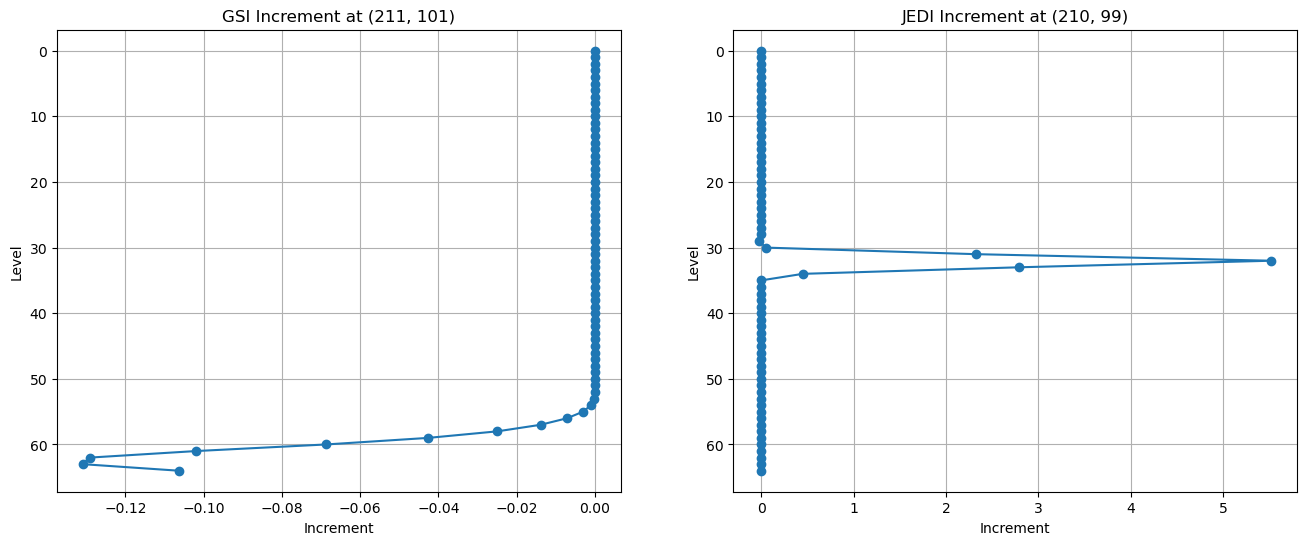

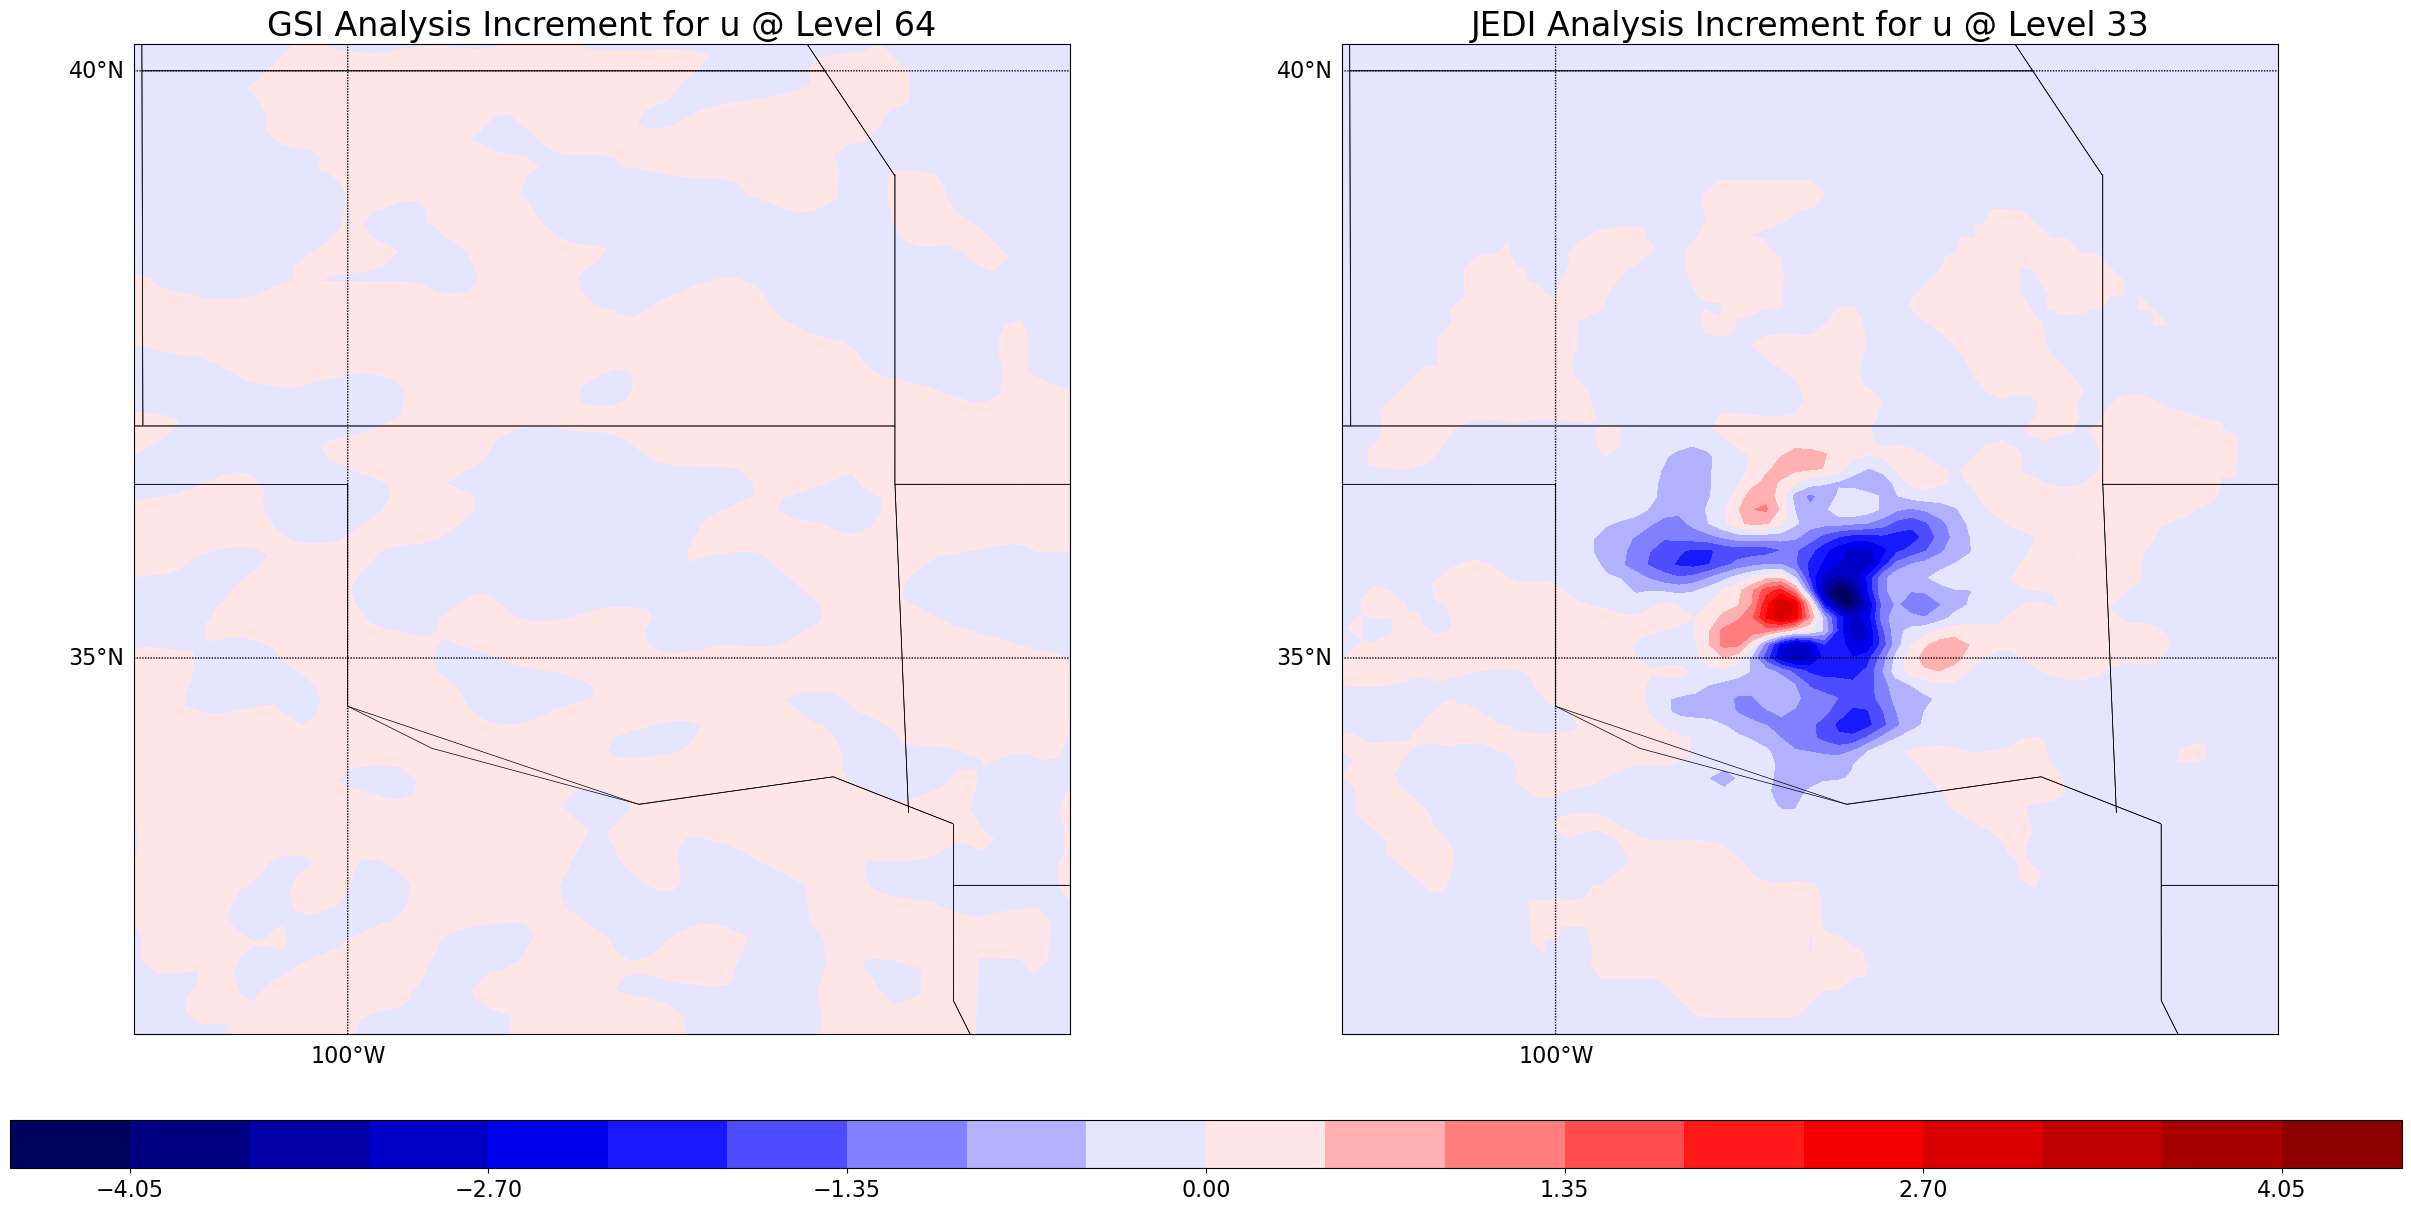

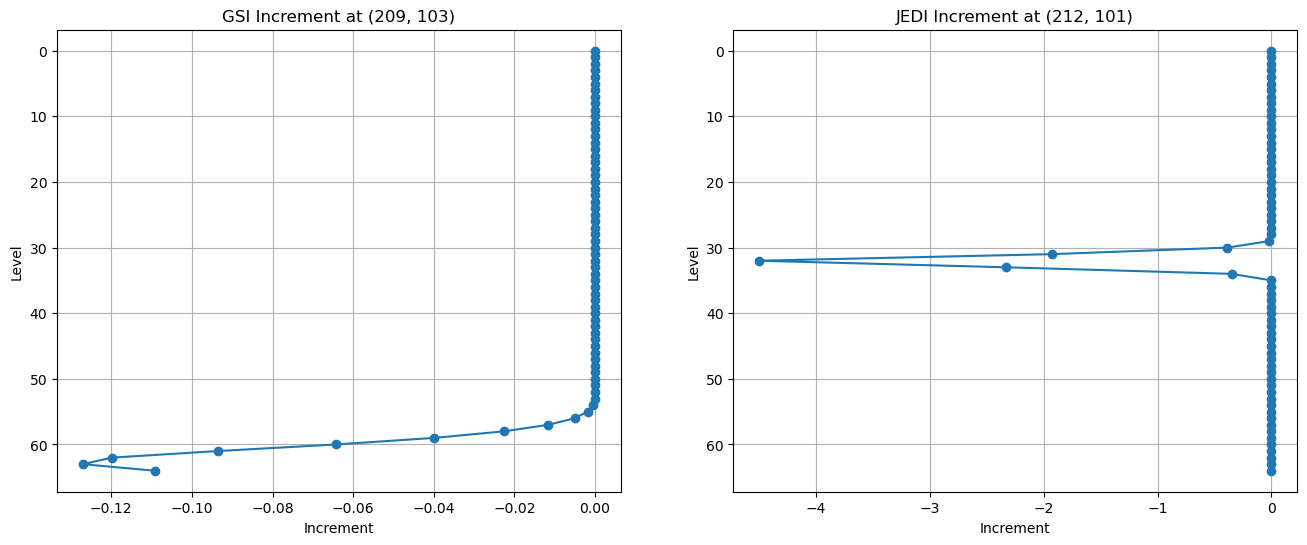

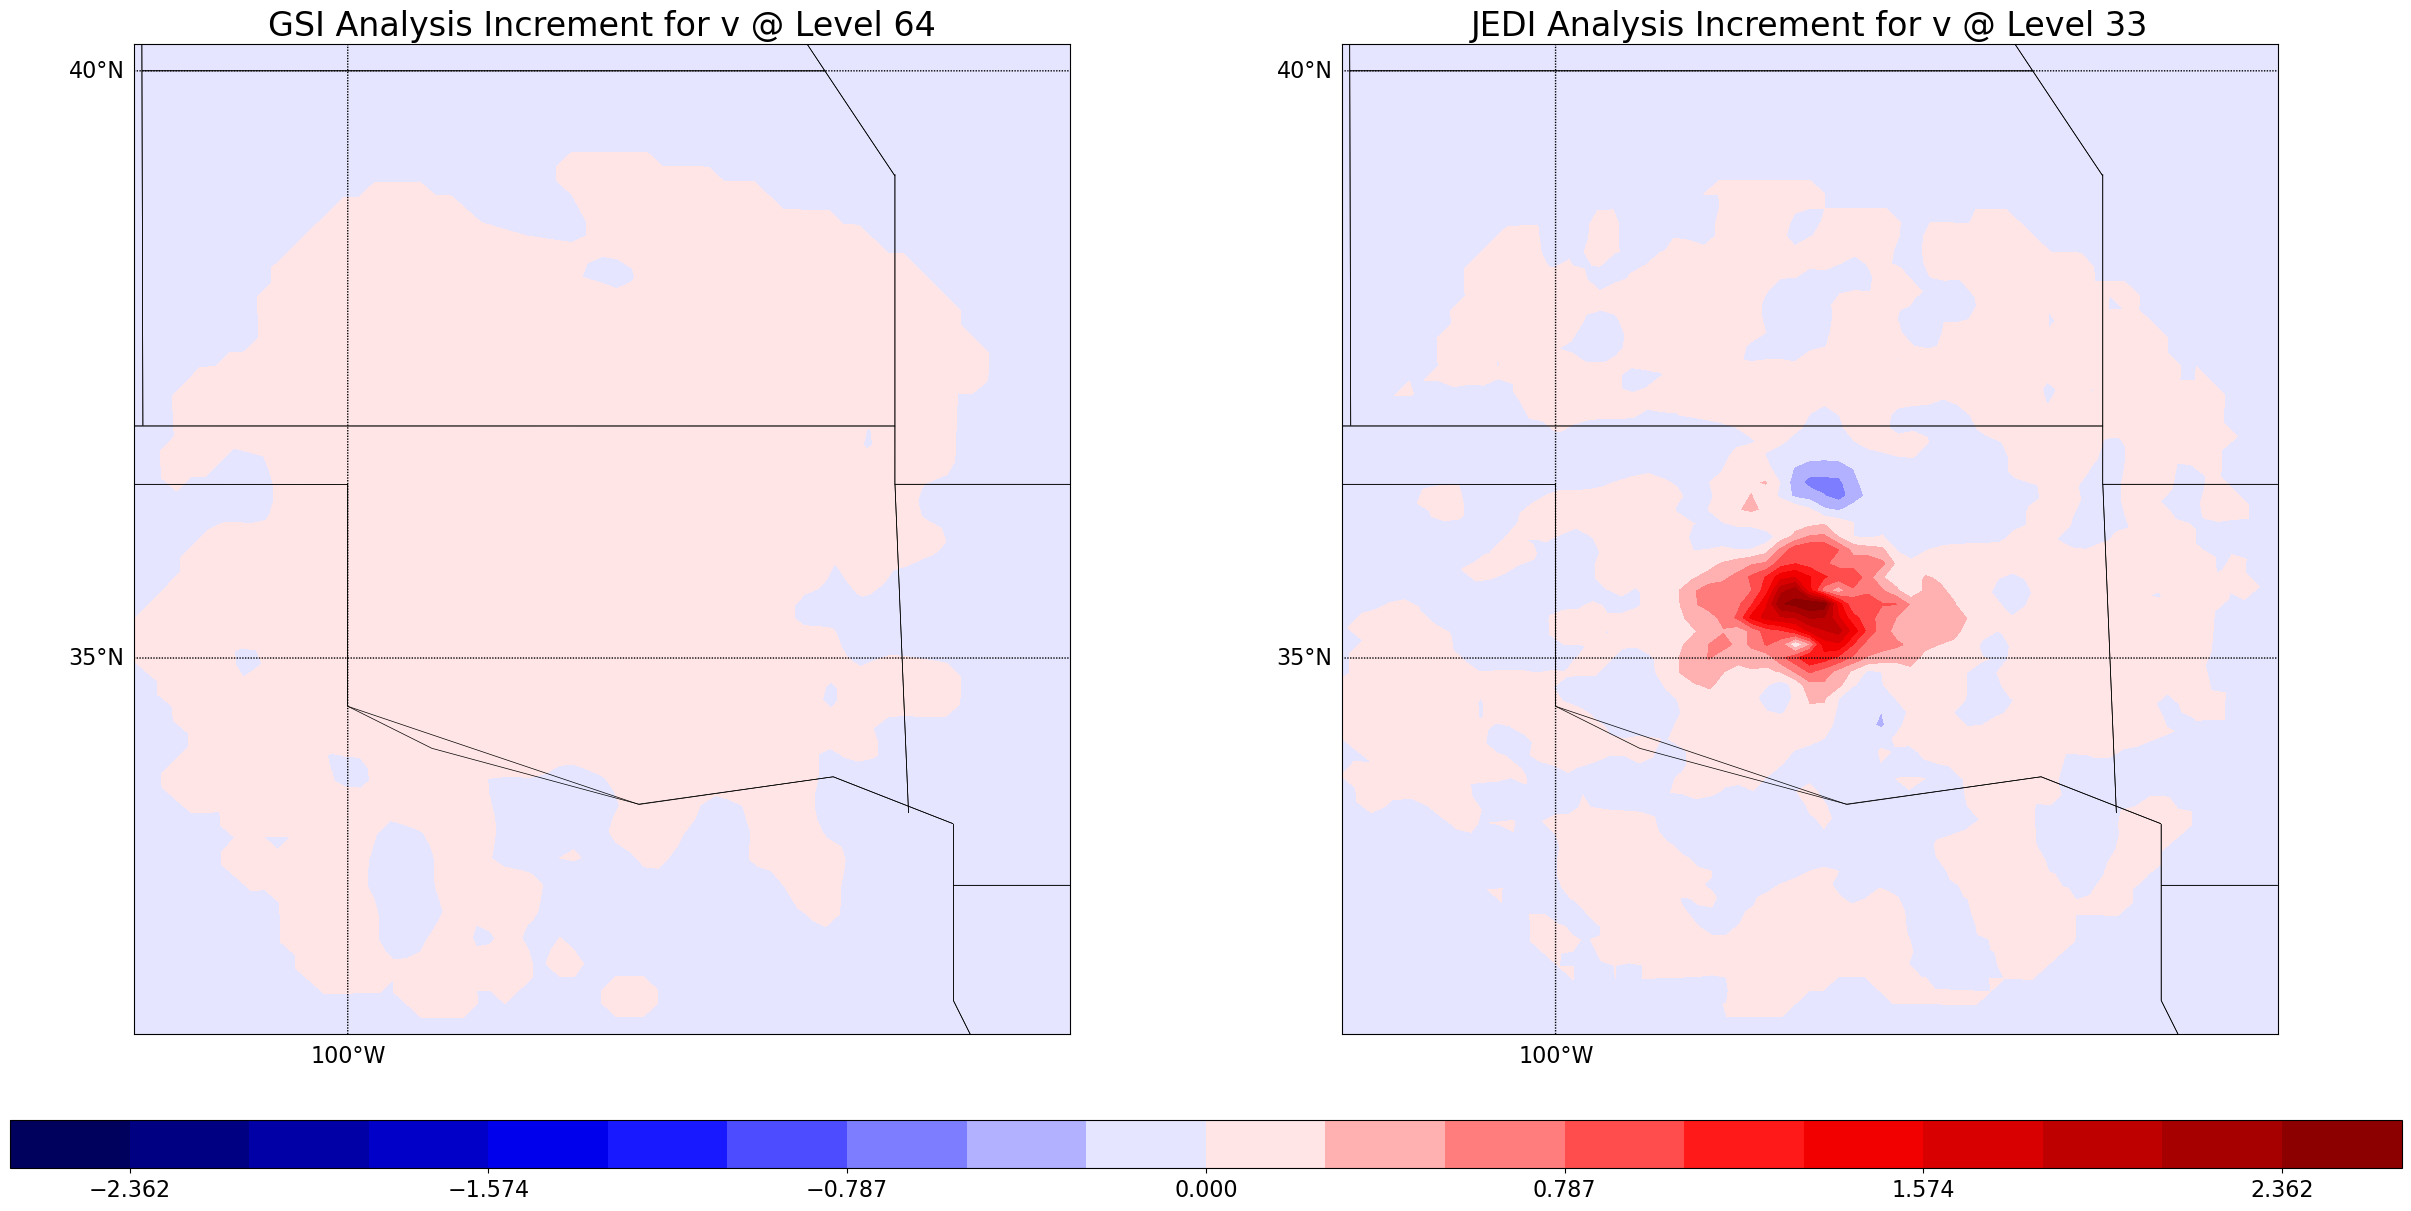

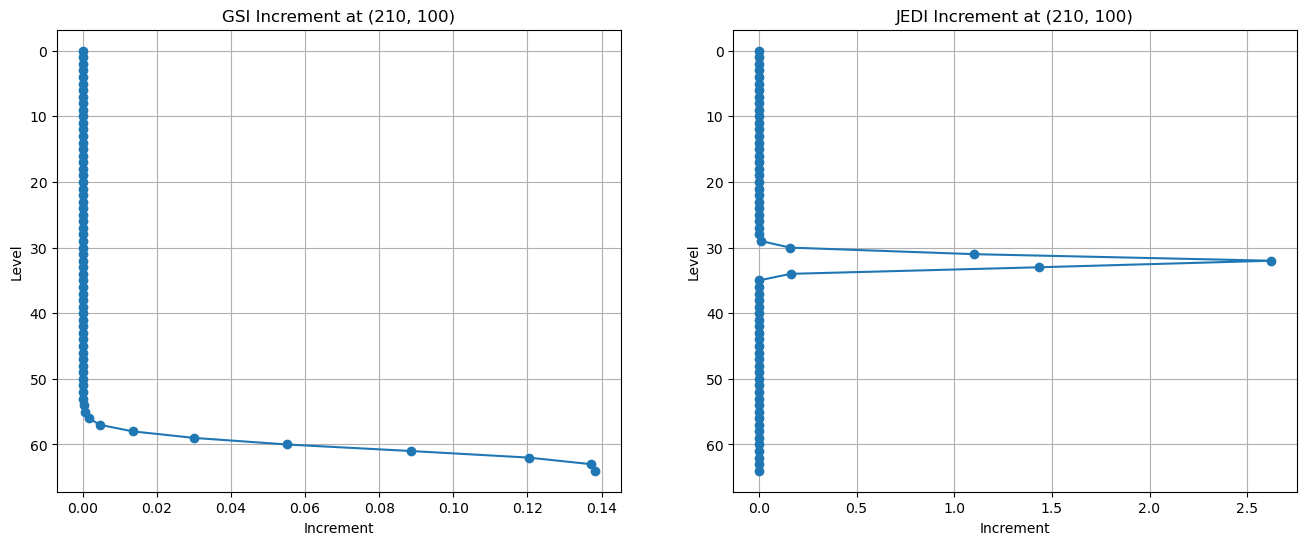

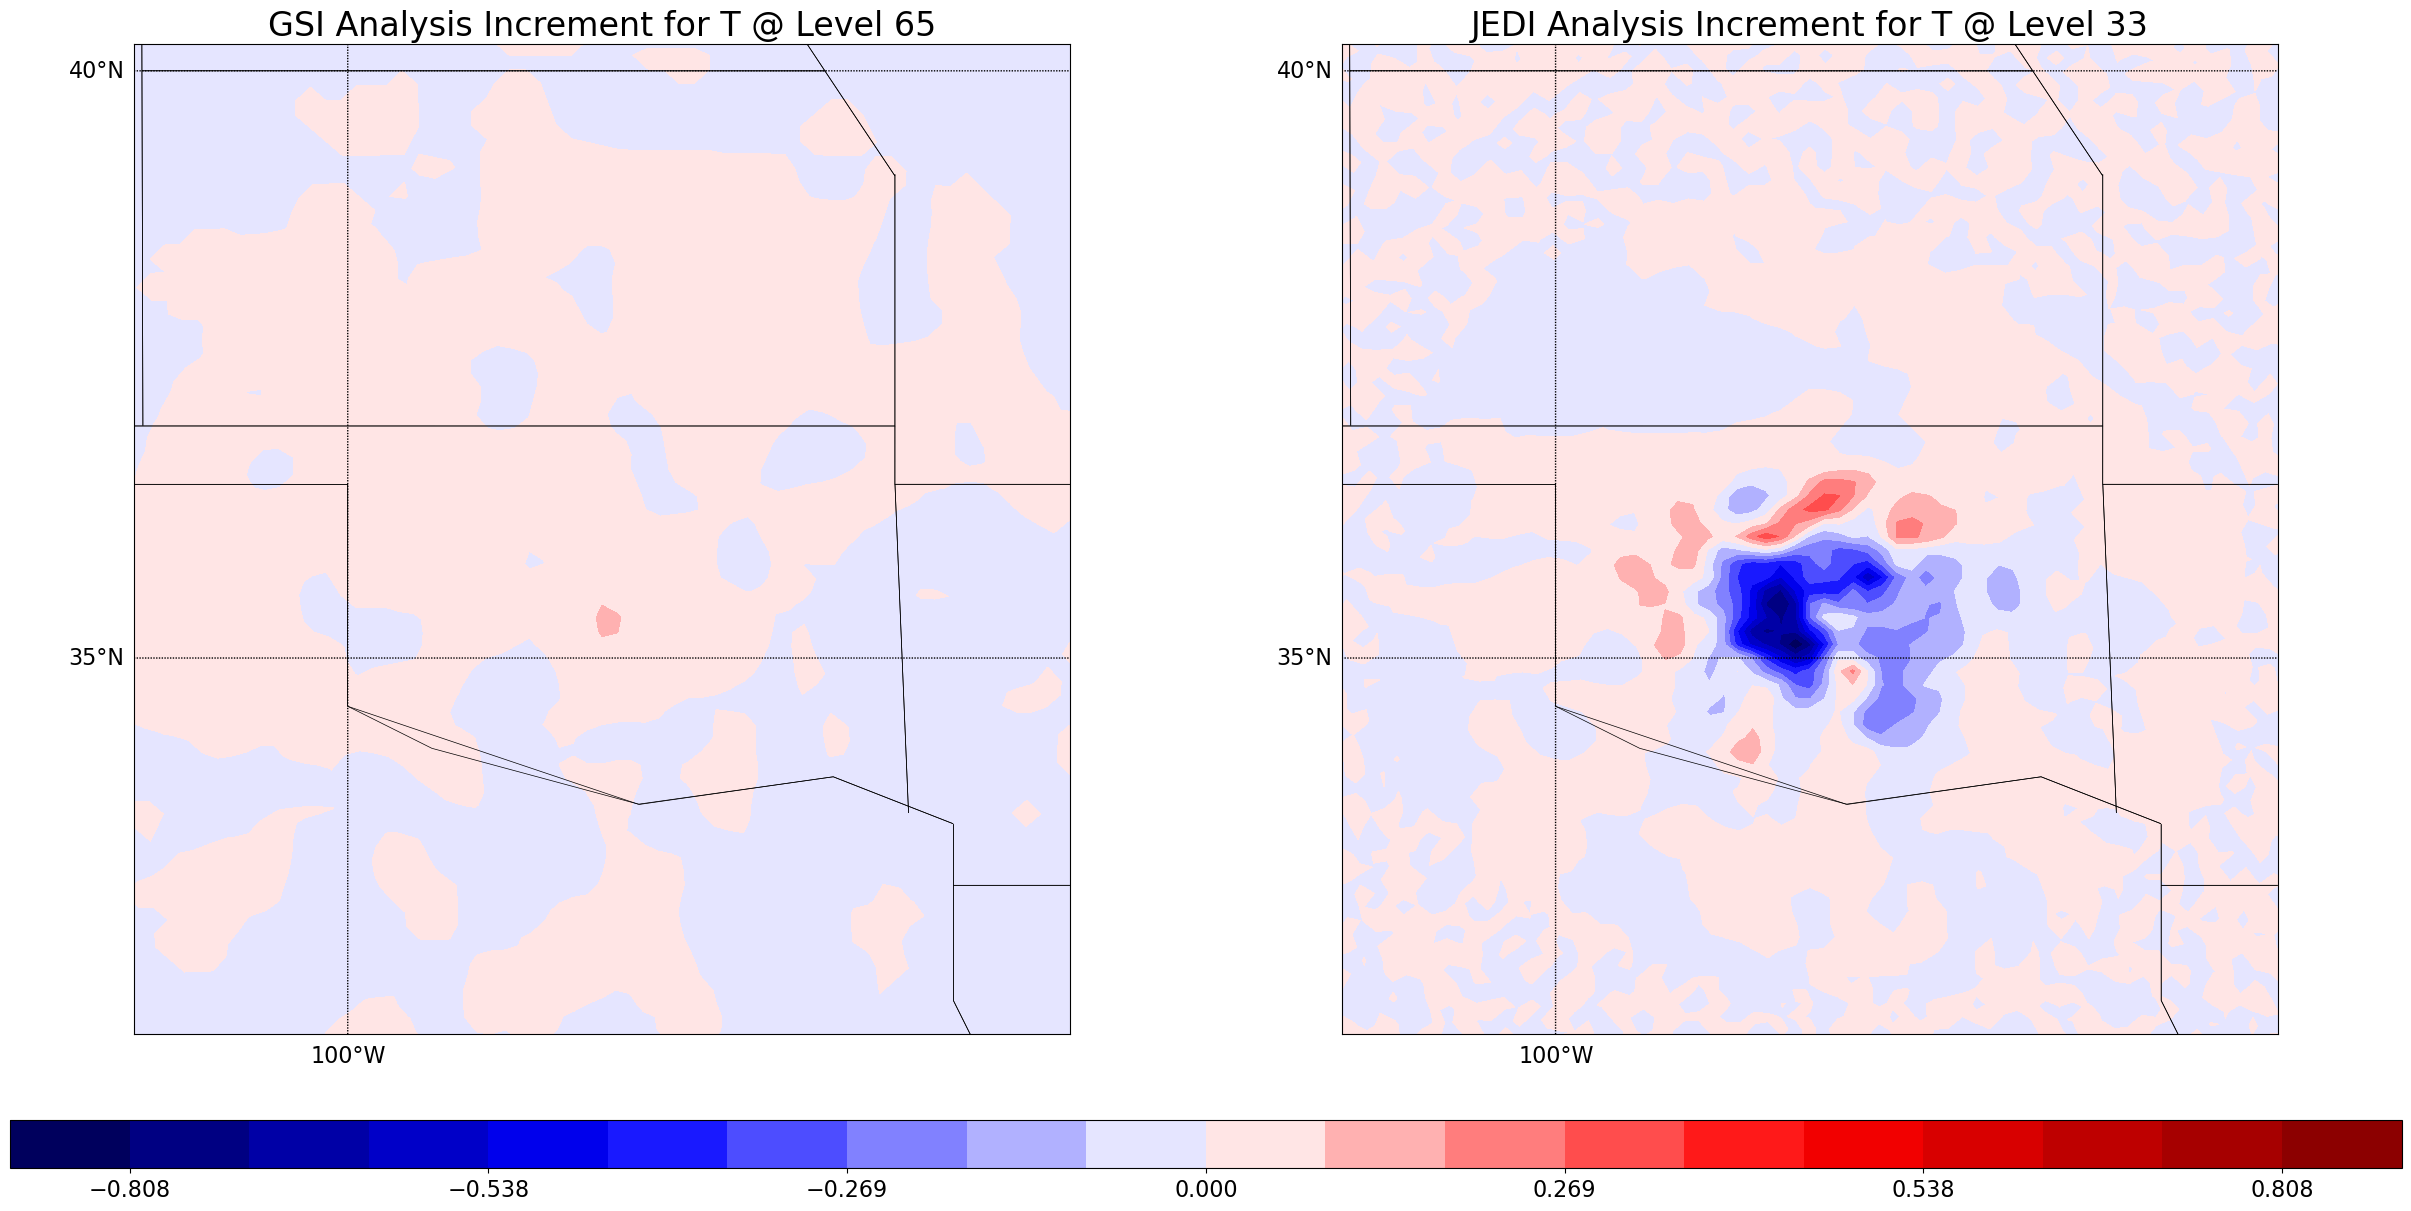

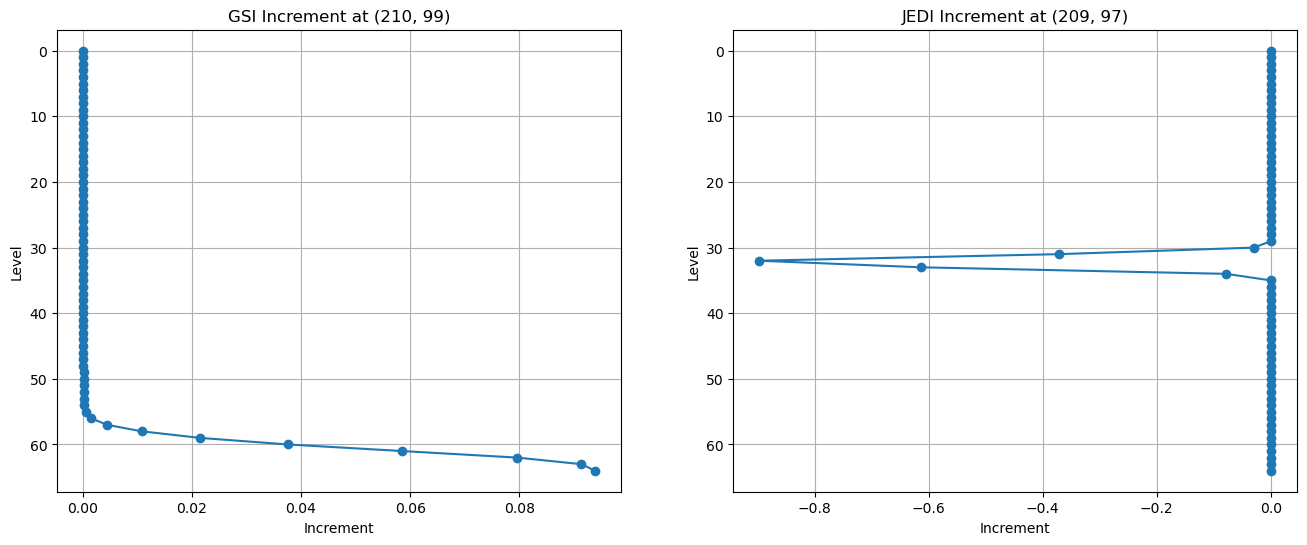

In [18]:
for var in var_loc.keys():
    print("Processing variable: {}".format(var))    
    gsi, jedi, bkg = [var_loc[var][stage][var][::] for stage in ['gsi', 'jedi', 'bkg']]
    if var == "sphum":
        gsi = gsi * 1000.
        jedi = jedi * 1000.
        bkg = bkg * 1000.
    gsi_increment = np.squeeze(gsi)[:, :, :]-np.squeeze(bkg)[:, :, :]
    jedi_increment = np.squeeze(jedi)[:, :, :]-np.squeeze(bkg)[:, :, :]
    (k1, j1, i1) = find_max_index(gsi_increment)
    (k2, j2, i2) = find_max_index(jedi_increment)
    plot_data(gsi_increment[k1, :, :], jedi_increment[k2, :, :], grid_lat, grid_lon, title1, title2)
    title1 = f'GSI Analysis Increment for {var} @ Level {k1+1}'
    title2 = f'JEDI Analysis Increment for {var} @ Level {k2+1}'
    plot_data_1dvert(gsi_increment, jedi_increment, i1, j1, i2, j2)

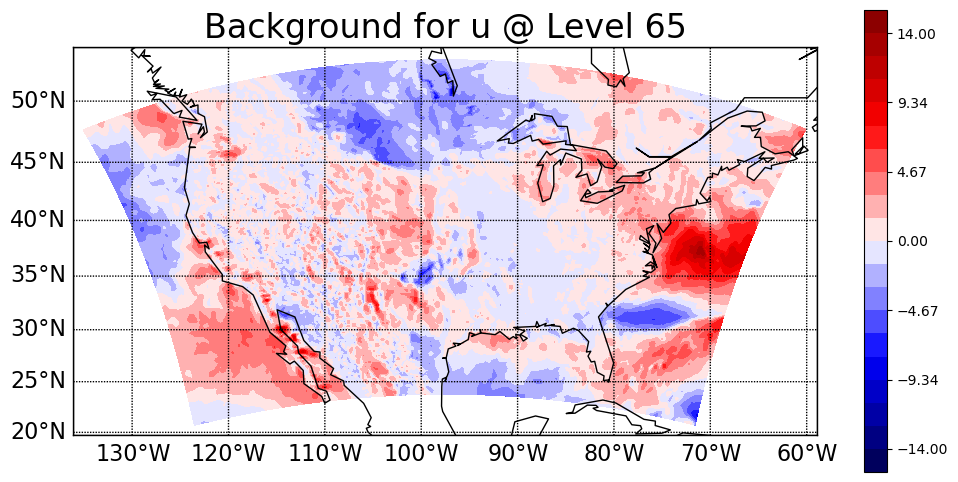

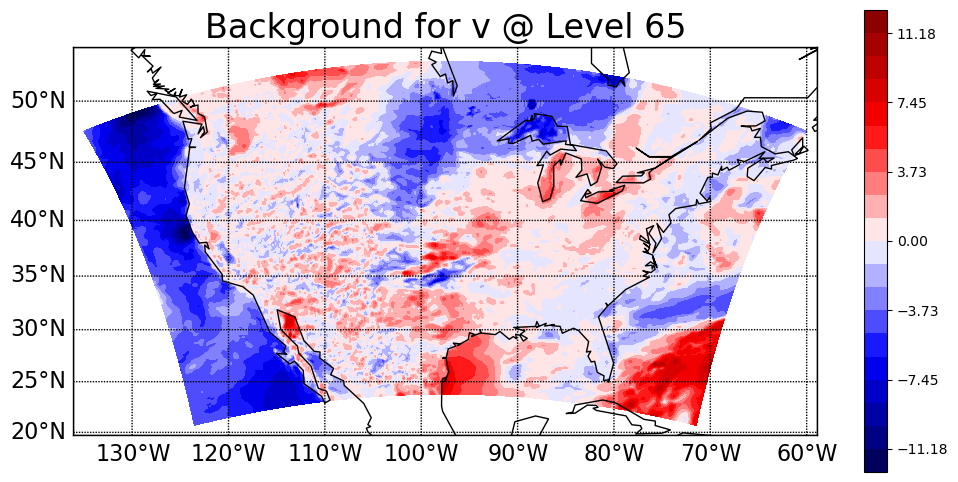

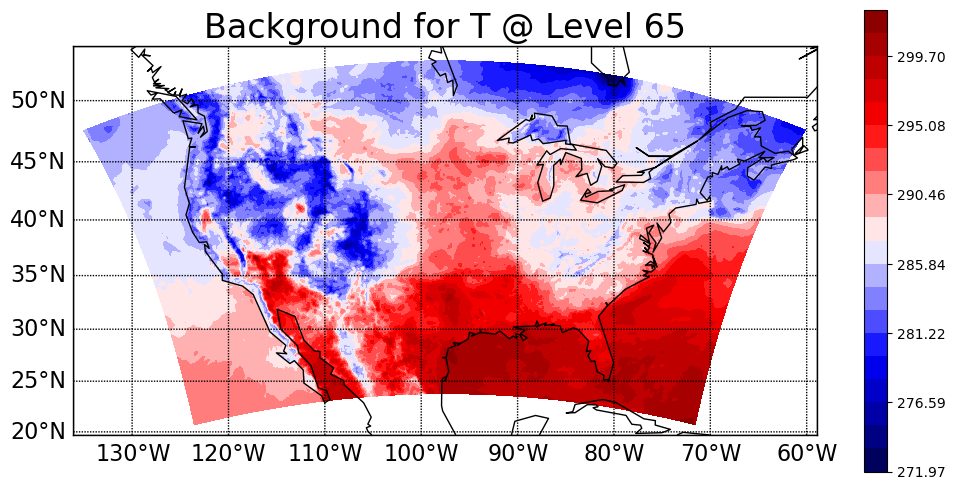

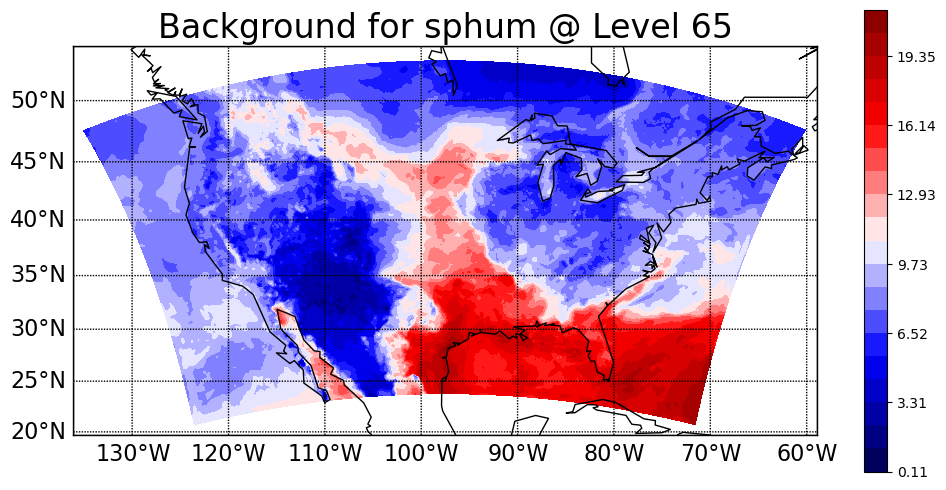

In [12]:
for var in var_loc.keys():
    lev = 64   # Change this variable to look at different vertical levels.       
    bkg = [var_loc[var]['bkg'][var][::]]
    data = np.squeeze(bkg)[lev, :, :]
    if var == "sphum":
        data = data * 1000.
    title = f'Background for {var} @ Level {lev+1}'
    plot_bkg(data, grid_lat, grid_lon, title)

# Explore the data

In [13]:
# Print just the variable names:
print('Dynamics variables include')
for var in gsi_dynam.variables:
    print(var)
for var in jedi_dynam.variables:
    print(var)

Dynamics variables include
xaxis_1
xaxis_2
yaxis_1
yaxis_2
zaxis_1
Time
u
v
W
DZ
T
delp
ua
va
phis
xaxis_1
xaxis_2
yaxis_1
yaxis_2
zaxis_1
zaxis_2
Time
u
v
ua
va
W
T
delp
phis


In [14]:
# Print more information about the variables
print('Dynamics file contains: ')
for var, info in gsi_dynam.variables.items():
    print(var, '------------\n', info)
    

Dynamics file contains: 
xaxis_1 ------------
 <class 'netCDF4._netCDF4.Variable'>
float32 xaxis_1(xaxis_1)
    axis: X
unlimited dimensions: 
current shape = (420,)
filling off
xaxis_2 ------------
 <class 'netCDF4._netCDF4.Variable'>
float32 xaxis_2(xaxis_2)
    axis: X
unlimited dimensions: 
current shape = (421,)
filling off
yaxis_1 ------------
 <class 'netCDF4._netCDF4.Variable'>
float32 yaxis_1(yaxis_1)
    axis: Y
unlimited dimensions: 
current shape = (253,)
filling off
yaxis_2 ------------
 <class 'netCDF4._netCDF4.Variable'>
float32 yaxis_2(yaxis_2)
    axis: Y
unlimited dimensions: 
current shape = (252,)
filling off
zaxis_1 ------------
 <class 'netCDF4._netCDF4.Variable'>
float32 zaxis_1(zaxis_1)
    axis: Z
unlimited dimensions: 
current shape = (65,)
filling off
Time ------------
 <class 'netCDF4._netCDF4.Variable'>
float32 Time(Time)
    cartesian_axis: T
    units: time level
    long_name: Time
unlimited dimensions: Time
current shape = (1,)
filling off
u -----------

In [15]:
# Access the data in a variable
u = gsi_dynam['u'][::]
u


masked_array(
  data=[[[[-25.774736  , -25.801983  , -25.833868  , ..., -23.29302   ,
           -23.54678   , -23.86546   ],
          [-25.968401  , -26.020134  , -26.073801  , ..., -23.273026  ,
           -23.559017  , -23.89723   ],
          [-26.166088  , -26.218702  , -26.28772   , ..., -23.251116  ,
           -23.583975  , -23.975622  ],
          ...,
          [-13.830857  , -14.070339  , -14.407311  , ..., -15.79426   ,
           -15.560577  , -15.219067  ],
          [-13.750446  , -13.792206  , -14.021217  , ..., -15.65461   ,
           -15.422612  , -15.103779  ],
          [-13.794777  , -13.658832  , -13.683307  , ..., -15.548131  ,
           -15.315109  , -15.057792  ]],

         [[-24.794174  , -24.853123  , -24.906876  , ..., -20.094164  ,
           -20.493235  , -20.886505  ],
          [-24.513304  , -24.601822  , -24.67018   , ..., -19.953285  ,
           -20.266481  , -20.507639  ],
          [-24.276957  , -24.36819   , -24.428839  , ..., -19.888294  ,
 

In [16]:
# What is the size of the data?
np.shape(u)

(1, 65, 253, 420)

In [17]:
var_loc = {
    'u': {
        'gsi': gsi_dynam,
        'jedi': jedi_dynam,
        'bkg': bkg_dynam,
    },
    'v':  {
        'gsi': gsi_dynam,
        'jedi': jedi_dynam,
        'bkg': bkg_dynam,
    },
    'T':  {
        'gsi': gsi_dynam,
        'jedi': jedi_dynam,
        'bkg': bkg_dynam,
    },
    'sphum':  {
        'gsi': gsi_tracer,
        'jedi': jedi_tracer,
        'bkg': bkg_tracer,
    },
    'phis':  {
        'gsi': gsi_dynam,
        'jedi': jedi_dynam,
        'bkg': bkg_dynam,
    },
}
for var in var_loc.keys():
    lev = 64   # Change this variable to look at different vertical levels.    
    
    bkg = [var_loc[var]['bkg'][var][::]]
    if var == "phis":
        data = np.squeeze(bkg)[:, :]
    else:
        data = np.squeeze(bkg)[lev, :, :]
    if var == "sphum":
        data = data * 1000.
    lat_trim, lon_trim = trim_grid(data, grid_lat, grid_lon)
    
    lat_flat = lat_trim.flatten()
    lon_flat = lon_trim.flatten()
    data_flat = data.flatten()
    
    points = np.column_stack((lat_flat, lon_flat))
    
    target_lat = 35.5 
    target_lon = -97.5
    target_point = np.array([[target_lat, target_lon+360]])

    # Perform the interpolation
    if (lat_trim.min() <= target_lat <= lat_trim.max()) and (lon_trim.min() <= target_lon+360 <= lon_trim.max()):
        # Interpolate to find the data value at the given lat and lon
        interpolated_value = griddata(points, data_flat, target_point, method='linear')
        print("Interpolated value at ({}, {}) and level {}: {}".format(target_lat, target_lon, lev+1, interpolated_value))
    else:
        print("Given lat/lon point ({}, {}) is outside the bounds of the data.".format(target_lat, target_lon))
    

Interpolated value at (35.5, -97.5) and level 65: [-0.97680706]
Interpolated value at (35.5, -97.5) and level 65: [-4.09313634]
Interpolated value at (35.5, -97.5) and level 65: [291.82728488]
Interpolated value at (35.5, -97.5) and level 65: [12.81150063]
Interpolated value at (35.5, -97.5) and level 65: [3512.46585795]
